In [4]:
import os
import pathlib
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from multiprocessing import Pool
import psutil
from climatenet.utils.data import ClimateDataset
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events
import torch
import numpy as np
from os import path
import pandas as pd

config = Config('/home/sbk29/data/github_AR/AR_detection/climatenet/config_new.json')
model = CGNet(config)

In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
torch.cuda.get_device_name(torch.cuda.device)

'NVIDIA A100 80GB PCIe'

In [1]:
import numpy as np

# Replace with your .npy file path
file_path = "/home/sbk29/data/ClimateNet/CGNet_predictions.npy"

# Load the .npy file
CGNet_predictions = np.load(file_path)

# View the contents
print(CGNet_predictions.shape)
# print(CGNet_predictions)

(61, 768, 1152)


In [7]:
inference_set = ClimateDataset('/home/sbk29/data/AR/test', model.config)

AttributeError: 'ClimateDataset' object has no attribute 'values'

In [3]:
def visualize_events(event_masks_xarray, input_data : ClimateDataset, png_dir):
    """Generates PNGs of event masks with TMQ background

    The PNGs can later be stitched together to a video with a tool such as ffmpeg. E.g. use
    ffmpeg -r 5 -pattern_type glob -i 'png_dir/*.png' -c:v libx264 -pix_fmt yuv420p 
           -vf scale=1920:1080,fps=29 -crf 29 -preset veryslow video.mp4

    Keyword arguments:
    input_data -- a ClimateDataset containt TMQ
    event_masks_xarray -- the event masks as xarray with IDs as elements 
    png_dir -- the directory where the PNGs get saved to
    """

    # create png_dir if it doesn't exist
    pathlib.Path(png_dir).mkdir(parents=True, exist_ok=True) 

    event_masks = event_masks_xarray.values

    # latitude and longitude grid
    lat = event_masks_xarray.lat
    lon = event_masks_xarray.lon

    # set cartopy background dir to include blue marble
    os.environ['CARTOPY_USER_BACKGROUNDS'] = str(os.getcwd() + '/climatenet/bluemarble')

    def map_instance():
        """Returns a matplotlib instance with bluemarble background"""
        plt.figure(figsize=(100,20),dpi=100)
        plt.rc('xtick',labelsize=20)
        plt.rc('ytick',labelsize=20)
        mymap = plt.subplot(111,projection=ccrs.PlateCarree())
        mymap.set_global()
        mymap.background_img(name='BM')
        mymap.coastlines()
        mymap.gridlines(crs=ccrs.PlateCarree(),linewidth=2, color='k', alpha=0.5, linestyle='--')
        mymap.set_xticks([-180,-120,-60,0,60,120,180])
        mymap.set_yticks([-90,-60,-30,0,30,60,90])
        plt.title("AR and TC Event Tracking", fontdict={'fontsize': 44})
        
        return mymap

    def generatePNG(filepath, tmq_data, event_mask):
        """Save a PNG of tmq_data and event_mask filepath"""

        mymap = map_instance()

        # contour data
        colors_1 = [(252-32*i,252-32*i,252-32*i,i*1/16) for i in np.linspace(0, 1, 32)]
        colors_2 = [(220-60*i,220-60*i,220,i*1/16+1/16) for i in np.linspace(0, 1, 32)]
        colors_3 = [(160-20*i,160+30*i,220,i*3/8+1/8) for i in np.linspace(0, 1, 96)]
        colors_4 = [(140+80*i,190+60*i,220+30*i,i*4/8+4/8) for i in np.linspace(0, 1, 96)]
        colors = colors_1 + colors_2 + colors_3 + colors_4
        colors = list(map(lambda c: (c[0]/256,c[1]/256,c[2]/256,c[3]), colors))
        data_cmap = mpl.colors.LinearSegmentedColormap.from_list('mycmap', colors, N=64) 

        data_contour = mymap.contourf(lon,lat,tmq_data,128,vmin=0,vmax=89, cmap=data_cmap,
                                      levels=np.arange(0,89,2),transform=ccrs.PlateCarree())
        
        # contour events   
        ls = np.linspace(0,1,2000)
        np.random.shuffle(ls)
        event_cmap = ListedColormap([1,1,1,0.3] * np.concatenate((np.zeros((1,4)), plt.cm.hsv(ls))))
        event_contourf = mymap.contourf(lon,lat,event_mask,cmap=event_cmap,
                                    vmin=0,vmax=len(event_cmap.colors)-1,levels=np.arange(len(event_cmap.colors)),
                                    norm=mpl.colors.Normalize(vmin=0, vmax=len(event_cmap.colors)-1))
        event_contour = mymap.contour(lon,lat,event_mask,colors=['#000000ff'])
        
        #colorbar and legend
        cbar = mymap.get_figure().colorbar(data_contour,ticks=np.arange(0,89,11),orientation='vertical')
        cbar.ax.set_ylabel('Integrated Water Vapor kg $m^{-2}$',size=32)

        #savefig
        mymap.get_figure().savefig(filepath,bbox_inches="tight",facecolor='w')

    print('generating images..', flush=True)

    global spawn # make function visible to pool
    def spawn(i):
        filename = png_dir + f"{i:04d}.png"
        generatePNG(filename, input_data[int(i/8)].sel(variable="TMQ")[i%8],
                    event_masks[i])

    pool = Pool(psutil.cpu_count(logical=False))
    pool.map(spawn, range(len(event_masks)))


In [17]:
config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
print(config.num_classes)  # should be 3
cgnet = CGNet(config)


training_set = ClimateDatasetLabeled('/home/sbk29/data/AR/train', model.config)
inference_set = ClimateDataset('/home/sbk29/data/AR/test', model.config)

# local_state_dict = torch.load('/home/sbk29/data/ClimateNet/weights.pth', map_location="cuda", weights_only=True)

model.load_model('/home/sbk29/data/ClimateNet/climatenet/')



predictions = model.predict(inference_set)
print(predictions.shape)

2


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:02,  2.54it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 25%|██▌       | 2/8 [00:00<00:02,  2.50it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 38%|███▊      | 3/8 [00:01<00:02,  2.41it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 50%|█████     | 4/8 [00:01<00:01,  2.26it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 62%|██████▎   | 5/8 [00:02<00:01,  2.27it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 75%|███████▌  | 6/8 [00:02<00:00,  2.27it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 88%|████████▊ | 7/8 [00:03<00:00,  2.27it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]

Output shape : torch.Size([5, 2, 768, 1152])
(5, 2, 768, 1152)
(61, 2, 768, 1152)


In [11]:
np.save('/home/sbk29/data/ClimateNet/predictions_probabilities.npy', predictions) # /home/sbk29/data/ClimateNet/check.ipynb

In [18]:
print(len(np.unique(predictions[0,:,:])))

862480


In [3]:
predictions = np.load("/home/sbk29/data/ClimateNet/CGNet_predictions_CE.npy")

In [5]:
predictions.shape

(61, 2, 768, 1152)

In [ ]:
threshold = 0.5
binary_mask = (predictions[7,,:,:]).astype(np.uint8)

plt.hist(binary_mask)

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [19]:
print(np.unique(predictions[0,:,:]))

[4.1893661e-28 4.3442870e-28 4.5049360e-28 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


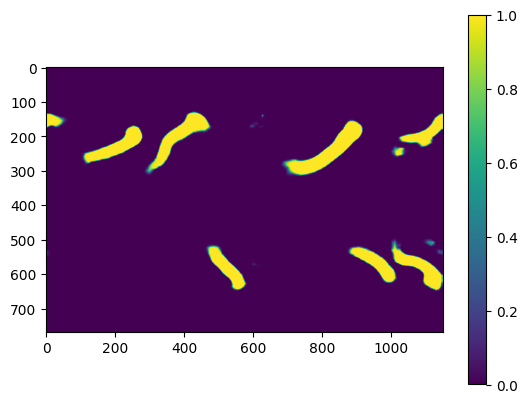

In [20]:
import matplotlib.pyplot as plt

plt.imshow(predictions[60,1,:,:])
plt.colorbar()
plt.show()

In [19]:
import cv2
import numpy as np

# Load your binary image. Make sure the image is in grayscale.
# If you already have a binary image as a NumPy array, skip the reading step.
# binary_image = cv2.imread('path_to_your_binary_image.png', cv2.IMREAD_GRAYSCALE)
# Convert probabilities to binary image (0 and 255 for OpenCV)
threshold = 0.6
binary_mask = (predictions[60,2,:,:] > threshold).astype(np.uint8) * 255
# Label connected components (objects)

# print(binary_mask.values)
# Optionally, threshold the image if it's not already binary:
_, binary_image = cv2.threshold(binary_mask.values, 127, 255, cv2.THRESH_BINARY)

# Use OpenCV's connectedComponents function
# The function returns the number of labels and the labeled image.
num_labels, labels_im = cv2.connectedComponents(binary_image)

# The background is typically labeled as 0, so the number of objects is num_labels - 1.
num_objects = num_labels - 1
print(f"Number of objects (using OpenCV): {num_objects}")


Number of objects (using OpenCV): 10


TypeError: Invalid shape (3, 768, 1152) for image data

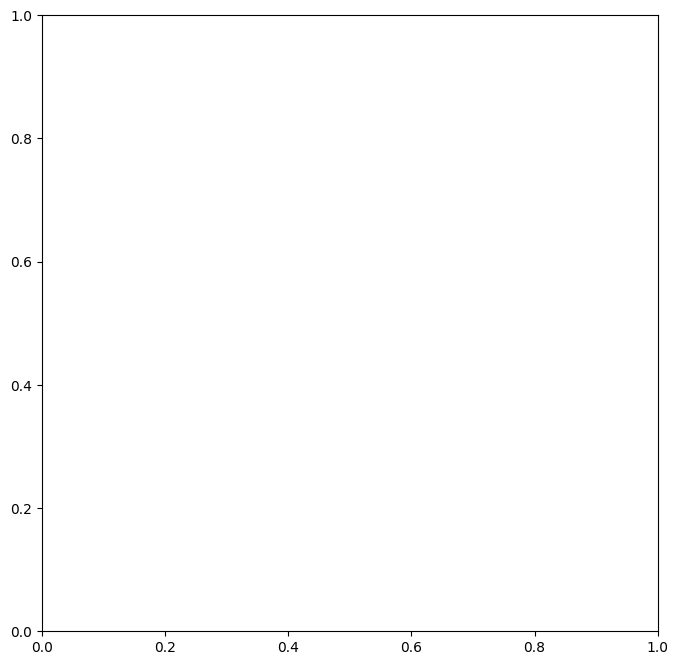

In [9]:
import matplotlib.pyplot as plt
from skimage import measure
# Label connected components (objects)
binary_mask = (predictions[0,:,:].values > 0.3).astype(np.uint8)   # 8-connectivity for 2D
labeled_mask = measure.label(binary_mask, connectivity=2) 
# Get properties of labeled regions
props = measure.regionprops(labeled_mask)

# Extract the centroids (note: regionprops returns (row, col) which corresponds to (y, x))
centroids = np.array([prop.centroid for prop in props])

# Plot the binary mask and overlay the centroids
plt.figure(figsize=(8, 8))
plt.imshow(binary_mask, cmap='gray')
if centroids.size > 0:
    # Scatter expects (x, y) so we swap the columns accordingly
    plt.scatter(centroids[:, 1], centroids[:, 0], color='red', s=100, marker='x')
plt.title('Centroids of Objects')
plt.axis('off')
plt.show()

In [7]:
np.int = int
# class_masks = cgnet.predict(inference) # masks with 1==TC, 2==AR
event_masks = track_events(predictions) # masks with event IDs

# analyze_events(event_masks, predictions, 'results/')
visualize_events(event_masks, inference, 'pngs/')


identifying connected components..
tracking components across time..


100%|██████████| 61/61 [01:19<00:00,  1.30s/it]


num TCs: 0
num ARs: 0


NameError: name 'inference' is not defined

In [11]:
from climatenet.utils.data2 import ClimateDatasetLabeled, ClimateDataset
from climatenet.models2 import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events

from os import path

config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
# print(config.num_classes)  # should be 3
cgnet = CGNet(config)

train_path = '/home/sbk29/data/AR/'
inference_path = '/home/sbk29/data/AR/'



In [5]:
config.epochs

20

In [9]:
train = ClimateDatasetLabeled(path.join(train_path, 'train'), config)
test = ClimateDatasetLabeled(path.join(train_path, 'test'), config)
inference = ClimateDataset(inference_path, config)

In [11]:
train_dataset = train


In [12]:
# 2. Retrieve a single item (say the first sample)
features, labels, dist_map = train_dataset[0]


In [13]:
dist_map

tensor([[[[-157.4961, -157.0949, -156.6991,  ..., -225.0089, -225.0022,
           -225.0000],
          [-156.5817, -156.1782, -155.7801,  ..., -224.0089, -224.0022,
           -224.0000],
          [-155.6684, -155.2626, -154.8621,  ..., -223.0089, -223.0022,
           -223.0000],
          ...,
          [-341.4763, -340.9898, -340.5055,  ..., -208.1220, -208.2964,
           -208.4755],
          [-342.3497, -341.8644, -341.3814,  ..., -209.1071, -209.2808,
           -209.4590],
          [-343.2238, -342.7397, -342.2579,  ..., -210.0924, -210.2652,
           -210.4427]],

         [[ 460.1576,  459.7913,  459.4268,  ...,  551.3057,  551.8378,
            552.3713],
          [ 459.2276,  458.8605,  458.4954,  ...,  550.4589,  550.9918,
            551.5261],
          [ 458.2979,  457.9301,  457.5642,  ...,  549.6126,  550.1464,
            550.6814],
          ...,
          [ 342.4763,  341.9898,  341.5055,  ...,  403.9814,  404.7122,
            405.4442],
          [ 343.34

In [14]:
# 1. Check the length
print(f"Dataset size: {len(train_dataset)}")

# 2. Retrieve a single item (say the first sample)
features, labels, dist_map = train_dataset[0]

print("Features:", features)
print("Labels:", labels)
print("Distance Map:", dist_map)

# Or check just shapes:
print("Features shape:", features.shape)   # e.g. (time, variable, lat, lon)
print("Labels shape:", labels.shape)       # e.g. (time, lat, lon)
print("Dist map shape:", dist_map.shape)   # e.g. (time, lat, lon)


Dataset size: 398
Features: tensor([[[[-1.1892, -1.1892, -1.1892,  ..., -1.1892, -1.1892, -1.1892],
          [-1.1897, -1.1897, -1.1897,  ..., -1.1897, -1.1897, -1.1897],
          [-1.1902, -1.1902, -1.1902,  ..., -1.1902, -1.1902, -1.1902],
          ...,
          [-0.5620, -0.5621, -0.5622,  ..., -0.5616, -0.5617, -0.5619],
          [-0.5866, -0.5866, -0.5867,  ..., -0.5864, -0.5864, -0.5865],
          [-0.6777, -0.6777, -0.6777,  ..., -0.6777, -0.6777, -0.6777]],

         [[-0.7689, -0.7644, -0.7600,  ..., -0.7822, -0.7778, -0.7733],
          [-0.9516, -0.9465, -0.9414,  ..., -0.9665, -0.9615, -0.9566],
          [-0.9971, -0.9933, -0.9895,  ..., -1.0081, -1.0045, -1.0008],
          ...,
          [-0.9907, -0.9894, -0.9880,  ..., -0.9947, -0.9934, -0.9921],
          [-0.9164, -0.9157, -0.9150,  ..., -0.9184, -0.9178, -0.9171],
          [-0.8868, -0.8866, -0.8865,  ..., -0.8870, -0.8869, -0.8868]],

         [[-1.1256, -1.1299, -1.1340,  ..., -1.1128, -1.1171, -1.1214],
  

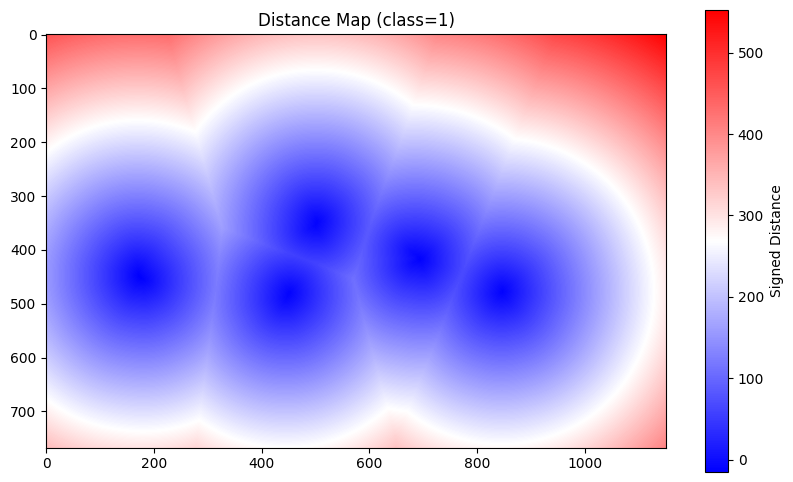

In [15]:
import matplotlib.pyplot as plt
import torch

# Suppose dist_map is a torch tensor with shape (1, 3, 768, 1152).
# We'll pick the first batch element (0) and then pick a specific class channel (e.g., 1).
batch_idx = 0
class_idx = 1  # pick which class channel to visualize

# Extract that 2D slice
dist_map_2d = dist_map[batch_idx, class_idx]  # shape (768, 1152)

# If it's on GPU, move it to CPU; then convert to NumPy if needed
dist_map_2d_np = dist_map_2d.detach().cpu().numpy()

# Plot using a diverging colormap (e.g., bwr) to highlight negative vs. positive
plt.figure(figsize=(10,6))
plt.imshow(dist_map_2d_np, cmap='bwr')
plt.colorbar(label='Signed Distance')
plt.title(f'Distance Map (class={class_idx})')
plt.show()





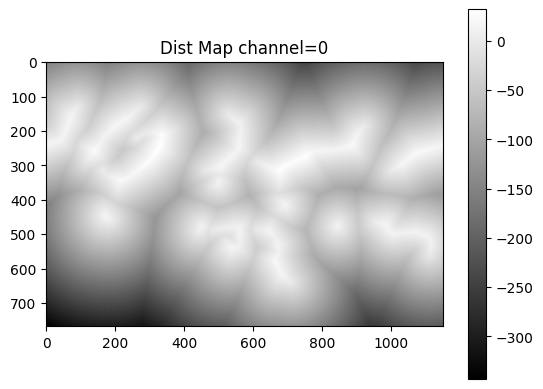

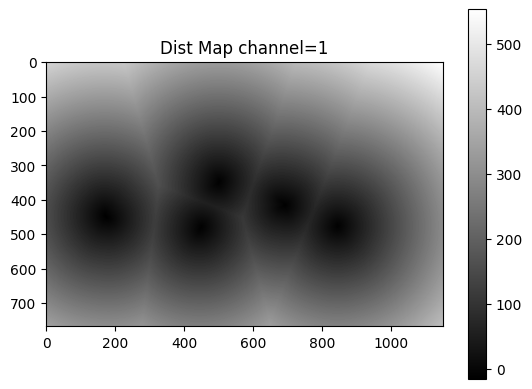

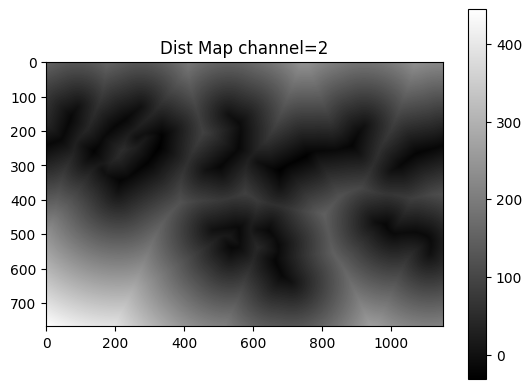

In [16]:
for c in range(dist_map.shape[1]):
    plt.figure()
    dist_2d_np = dist_map[0, c].cpu().numpy()
    plt.imshow(dist_2d_np, cmap='grey')
    plt.title(f'Dist Map channel={c}')
    plt.colorbar()
    plt.show()


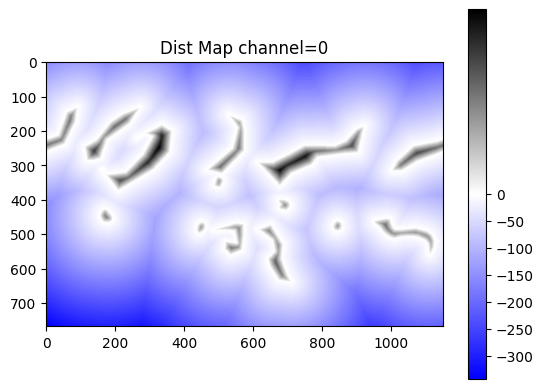

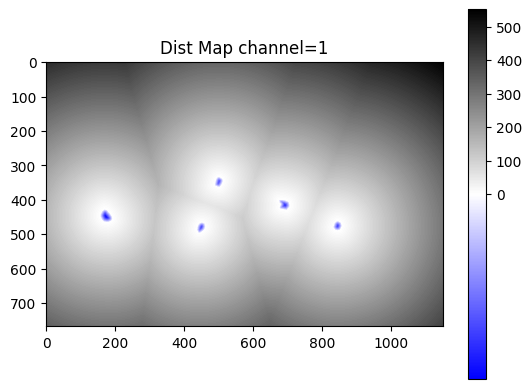

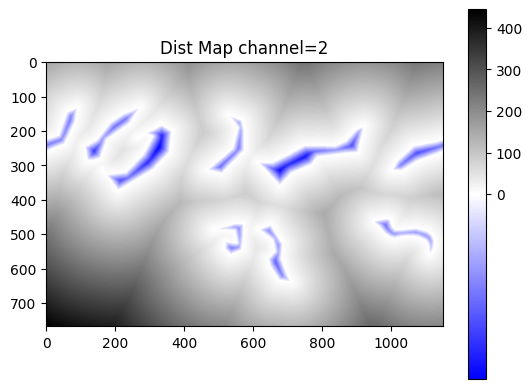

In [14]:
import matplotlib.colors as mcolors

# 1) Define a custom colormap that goes [blue -> white -> black].
#    We'll specify three points: 0.0 = blue, 0.5 = white, 1.0 = black.
my_cmap = mcolors.LinearSegmentedColormap.from_list(
    'BlueWhiteBlack',
    [(0.0, 'blue'), (0.5, 'white'), (1.0, 'black')]
)

# Suppose 'dist_map' is a PyTorch tensor with shape (B, C, H, W).
# We'll loop over channels in 'dist_map[0]' and plot them.
for c in range(dist_map.shape[1]):
    plt.figure()

    # 2) Convert to NumPy array for plotting.
    dist_2d_np = dist_map[0, c].cpu().numpy()  # shape (H, W)

    # 3) Use TwoSlopeNorm so that '0' is at the midpoint (white).
    dist_min, dist_max = dist_2d_np.min(), dist_2d_np.max()
    norm = mcolors.TwoSlopeNorm(vcenter=0.0, vmin=dist_min, vmax=dist_max)

    # 4) Plot using our custom colormap + the TwoSlopeNorm.
    plt.imshow(dist_2d_np, cmap=my_cmap, norm=norm)
    plt.title(f"Dist Map channel={c}")
    plt.colorbar()
    plt.show()


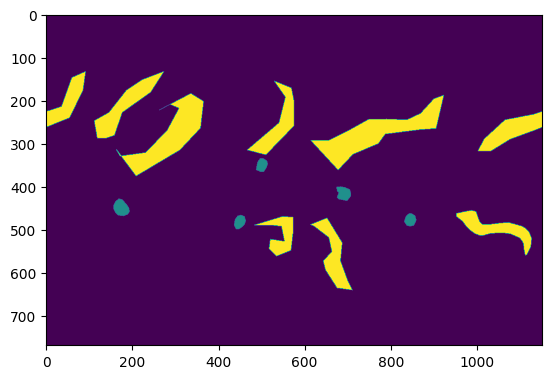

In [9]:
plt.imshow(labels.squeeze())

In [ ]:
config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
# print(config.num_classes)  # should be 3
cgnet = CGNet(config)

train_path = '/home/sbk29/data/AR/'
train_dataset = ClimateDatasetLabeled(path.join(train_path, 'train'), config)
cgnet.train_procrustes(train_dataset)

/home/sbk29/.conda/envs/turbulence/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1:


  0%|          | 0/100 [00:00<?, ?it/s]

labels shape : torch.Size([4, 768, 1152])
pred_probs shape: torch.Size([4, 2, 768, 1152])


In [3]:
cgnet.save_model('/home/sbk29/data/ClimateNet/climatenet/')

In [3]:
cgnet.save_model('/home/sbk29/data/ClimateNet/climatenet/')

In [6]:
inference_set = ClimateDataset('/home/sbk29/data/AR/test', cgnet.config)

In [7]:
import numpy as np
predictions = cgnet.predict(inference_set)
# print(predictions)
# np.save('/home/sbk29/data/ClimateNet/CGNet_predictions_surface_procrustes.npy', predictions)
# print("Model successfully saved")


 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 25%|██▌       | 2/8 [00:01<00:04,  1.33it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 38%|███▊      | 3/8 [00:02<00:03,  1.42it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 50%|█████     | 4/8 [00:02<00:02,  1.44it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 62%|██████▎   | 5/8 [00:03<00:02,  1.45it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 75%|███████▌  | 6/8 [00:04<00:01,  1.49it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 88%|████████▊ | 7/8 [00:04<00:00,  1.49it/s]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

Output shape : torch.Size([5, 2, 768, 1152])
(5, 2, 768, 1152)


In [7]:
from torch.utils.data import Dataset, DataLoader
config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
model = CGNet(config)
labeled_dataset = ClimateDatasetLabeled('/home/sbk29/data/AR/test', model.config)
loader = DataLoader(labeled_dataset, batch_size=1, collate_fn=ClimateDatasetLabeled.collate)
true_mask = []
# Iterate through all batches in the test loader
for batch_idx, (input_images, labels) in enumerate(loader):
    # Move data to the same device as the model
    # input_images = input_images.to(device)
    # labels = labels.to(device)
    true_mask.append(labels)



In [8]:
for batch in loader:
    print("Batch type:", type(batch))
    print("Number of items in batch:", len(batch))
    break

Batch type: <class 'tuple'>
Number of items in batch: 2


In [5]:
# Get a sample from the dataset
sample = labeled_dataset[0]
print("Length of sample:", len(sample))
for i, item in enumerate(sample):
    print(f"Sample item {i}: type={type(item)}", end="")
    try:
        print(f", shape={item.shape}")
    except AttributeError:
        print("")
        



Length of sample: 2
Sample item 0: type=<class 'xarray.core.dataarray.DataArray'>, shape=(1, 4, 768, 1152)
Sample item 1: type=<class 'xarray.core.dataarray.DataArray'>, shape=(768, 1152)


In [42]:
# Now, let's check what the collate function returns.
batch = [labeled_dataset[i] for i in range(3)]
collated_data = ClimateDatasetLabeled.collate(batch)
print("Collated batch type:", type(collated_data))
if isinstance(collated_data, tuple):
    print("Number of items in collated batch:", len(collated_data))
    for i, item in enumerate(collated_data):
        print(f"Collated item {i}: type={type(item)}", end="")
        try:
            print(f", shape={item.shape}")
        except AttributeError:
            print("")

Collated batch type: <class 'tuple'>
Number of items in collated batch: 2
Collated item 0: type=<class 'xarray.core.dataarray.DataArray'>, shape=(3, 4, 768, 1152)
Collated item 1: type=<class 'xarray.core.dataarray.DataArray'>, shape=(3, 768, 1152)


In [8]:
true_mask = np.array(true_mask)

In [8]:
true_mask.shape

(61, 1, 768, 1152)

In [5]:
# true_mask[true_mask == 1] = 0
# true_mask[true_mask == 2] = 1

In [9]:
np.unique(true_mask)


array([0, 1])

In [75]:
predictions = np.load("/home/sbk29/data/ClimateNet/CGNet_predictions.npy")

In [12]:
predictions.shape

(61, 768, 1152)

In [16]:
np.unique(predictions)

array([0, 1, 2])

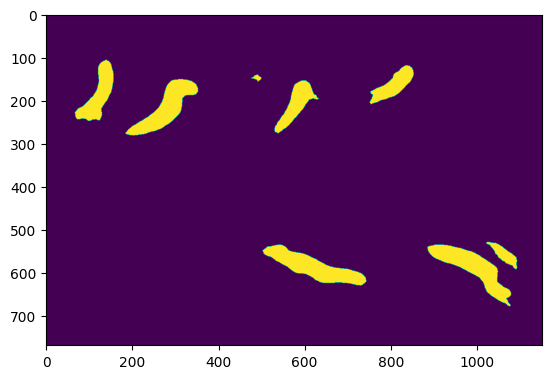

In [9]:
plt.imshow(predictions[50,1,:,:]> 0.5)

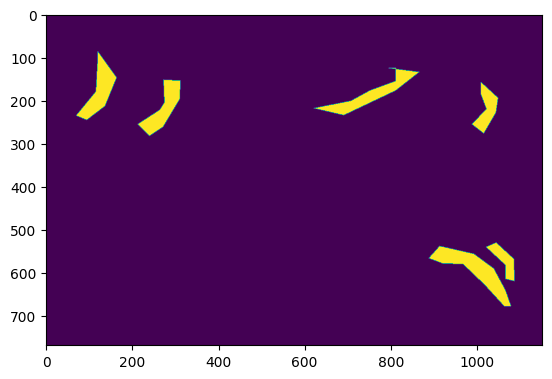

In [10]:
plt.imshow(true_mask[50,0,:,:])

In [30]:
def threat_score(pred_mask, true_mask):
    """
    Compute the Threat Score (TS) for binary masks.
    
    Args:
        pred_mask (np.array): Binary array of predicted events (1 = event, 0 = no event).
        true_mask (np.array): Binary array of observed events (1 = event, 0 = no event).
    
    Returns:
        float: Threat Score (TS)
    """
    A11 = np.logical_and(pred_mask == 1, true_mask == 1).sum()  # True Positives
    A10 = np.logical_and(pred_mask == 1, true_mask == 0).sum()  # False Positives
    A01 = np.logical_and(pred_mask == 0, true_mask == 1).sum()  # False Negatives

    TS = A11 / (A11 + A10 + A01) if (A11 + A10 + A01) > 0 else 0.0
    return TS


In [53]:
predictions = np.load("/home/sbk29/data/ClimateNet/CGNet_predictions_surface_procrustes.npy")

In [55]:
predictions.shape

(61, 3, 768, 1152)

In [ ]:
pre

In [13]:
predicted_mask.shape

(61, 768, 1152)

In [14]:
np.unique(predicted_mask)

array([False,  True])

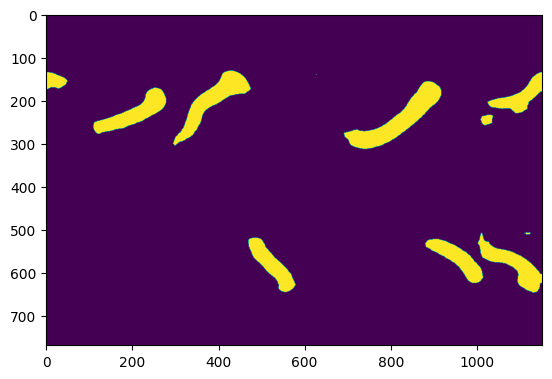

In [15]:
plt.imshow(predicted_mask[60,:,:])

In [70]:
predicted_mask = (predictions ==2)

# threat_score(predicted_mask, true_mask)

In [20]:
np.unique(predicted_mask)

array([False,  True])

In [13]:
predicted_mask = np.array(predicted_mask)

In [14]:
from sklearn.metrics import jaccard_score

In [15]:
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = true_mask.shape[0]
scores = []

for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = true_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.38662326380054773


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, find_contours
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import directed_hausdorff

# ----------------------------
# Function to compute symmetric Hausdorff distance between two contours.
# ----------------------------
def hausdorff_distance(contour1, contour2):
    d1 = directed_hausdorff(contour1, contour2)[0]
    d2 = directed_hausdorff(contour2, contour1)[0]
    return max(d1, d2)

total_hd = []  # List to store the average Hausdorff distance for each sample

num_samples = true_mask.shape[0]

for sample_idx in range(num_samples):
    # ----------------------------
    # Process the True Mask for this sample
    # ----------------------------
    labeled_true = label(true_mask[sample_idx, 0, :, :], connectivity=2)
    true_props = regionprops(labeled_true)
    true_label_to_centroid = {prop.label: prop.centroid for prop in true_props}
    true_centroids = np.array([prop.centroid for prop in true_props])
    true_labels = np.array([prop.label for prop in true_props])
    
    # ----------------------------
    # Process the Predicted Mask for this sample
    # ----------------------------
    binary_pred = predicted_mask[sample_idx, :, :] #.astype(np.uint8)
    labeled_pred = label(binary_pred, connectivity=2)
    pred_props = regionprops(labeled_pred)
    pred_label_to_centroid = {prop.label: prop.centroid for prop in pred_props}
    pred_centroids = np.array([prop.centroid for prop in pred_props])
    pred_labels = np.array([prop.label for prop in pred_props])
    
    # If there are no true objects or no predicted objects, skip this sample.
    if true_centroids.size == 0 or pred_centroids.size == 0:
        print(f"Sample {sample_idx}: No objects in true or predicted mask, skipping.")
        continue
    
    # ----------------------------
    # Assignment via Centroid Distance
    # ----------------------------
    cost_matrix = np.linalg.norm(true_centroids[:, np.newaxis, :] - pred_centroids[np.newaxis, :, :], axis=2)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    max_distance_threshold = 50  # maximum allowed distance for a valid assignment
    
    sample_hd_values = []  # list to store computed Hausdorff distances for this sample
    
    # ----------------------------
    # For Each Assigned Pair, Compute Hausdorff Distance
    # ----------------------------
    for t, p in zip(row_ind, col_ind):
        dist = cost_matrix[t, p]
        if dist > max_distance_threshold:
            print(f"Sample {sample_idx}: Skipping true object with centroid {true_centroids[t]} (distance: {dist:.2f} > threshold)")
            continue

        true_label = true_labels[t]
        pred_label = pred_labels[p]
        
        # Extract binary masks for the true and predicted objects.
        true_obj_mask = (labeled_true == true_label).astype(np.uint8)
        pred_obj_mask = (labeled_pred == pred_label).astype(np.uint8)
        
        # ----------------------------
        # Extract the Contours for Each Object
        # ----------------------------
        true_contours = find_contours(true_obj_mask, level=0.5)
        pred_contours = find_contours(pred_obj_mask, level=0.5)
        
        if len(true_contours) == 0 or len(pred_contours) == 0:
            print(f"Sample {sample_idx}: Could not extract contour for true label {true_label} or predicted label {pred_label}.")
            continue
        
        # Choose the longest contour (with most points) as the representative.
        true_contour = max(true_contours, key=len)
        pred_contour = max(pred_contours, key=len)
        
        # Compute the Hausdorff distance between the two contours.
        hd = hausdorff_distance(true_contour, pred_contour)
        
        
        
        sample_hd_values.append(hd)
        
        print(f"Sample {sample_idx}: True object (label {true_label}, centroid {true_label_to_centroid[true_label]}) "
              f"assigned to predicted object (label {pred_label}, centroid {pred_label_to_centroid[pred_label]}): "
              f"Hausdorff distance = {hd:.2f}")
        
        # Optional: Visualization of the pair (commented out)
        # plt.figure(figsize=(6, 6))
        # composite_mask = np.maximum(true_obj_mask, pred_obj_mask)
        # plt.imshow(composite_mask, cmap='gray', alpha=0.7)
        # plt.plot(true_contour[:, 1], true_contour[:, 0], 'r-', lw=2, label='True Contour')
        # plt.plot(pred_contour[:, 1], pred_contour[:, 0], 'b-', lw=2, label='Pred Contour')
        # plt.scatter([true_centroids[t][1], pred_centroids[p][1]], [true_centroids[t][0], pred_centroids[p][0]], 
        #             c=['green', 'orange'], s=100, label='Centroids')
        # plt.title(f"Hausdorff: {hd:.2f}")
        # plt.legend()
        # plt.axis("off")
        # plt.show()
    
    # Compute and store the average Hausdorff distance for this sample.
    if sample_hd_values:
        avg_sample_hd = np.mean(sample_hd_values)
        total_hd.append(avg_sample_hd)
        print(f"Sample {sample_idx}: Average Hausdorff Distance = {avg_sample_hd:.2f}")
    else:
        print(f"Sample {sample_idx}: No valid assignments to compute Hausdorff distance.")

# ----------------------------
# Compute the Overall Average Hausdorff Distance Across All Samples
# ----------------------------
if total_hd:
    overall_avg_hd = np.mean(total_hd)
    print(f"Overall Average Hausdorff Distance: {overall_avg_hd:.2f}")
else:
    print("No valid samples to compute overall Hausdorff distance.")


Sample 0: True object (label 1, centroid (222.04752337531875, 111.17000231821343)) assigned to predicted object (label 1, centroid (189.03712962962962, 122.93583333333333)): Hausdorff distance = 65.19
Sample 0: True object (label 2, centroid (250.86328040026103, 330.6438981944747)) assigned to predicted object (label 5, centroid (238.05409099785197, 377.94239406365944)): Hausdorff distance = 102.86
Sample 0: Skipping true object with centroid [ 266.40295359 1044.05406118] (distance: 158.57 > threshold)
Sample 0: Skipping true object with centroid [273.07772727 821.20727273] (distance: 74.70 > threshold)
Sample 0: Skipping true object with centroid [ 293.48598131 1144.22429907] (distance: 80.50 > threshold)
Sample 0: Skipping true object with centroid [518.9060559 511.9988354] (distance: 84.75 > threshold)
Sample 0: True object (label 7, centroid (547.6875712656785, 1042.357550089591)) assigned to predicted object (label 10, centroid (501.7849829351536, 1022.6348122866895)): Hausdorff d

Sample 15: True object (label 5, centroid (589.1463704630788, 1034.2831038798497)) assigned to predicted object (label 6, centroid (594.8169396161961, 1040.7790615894705)): Hausdorff distance = 25.24
Sample 15: True object (label 6, centroid (604.3581852333477, 645.582430284641)) assigned to predicted object (label 7, centroid (583.9278878255063, 615.6215223681282)): Hausdorff distance = 66.27
Sample 15: Average Hausdorff Distance = 44.62
Sample 16: True object (label 1, centroid (175.28793703093538, 905.3225334065531)) assigned to predicted object (label 1, centroid (178.23748773307165, 903.361138370952)): Hausdorff distance = 14.76
Sample 16: True object (label 2, centroid (205.42617866004963, 1037.512200165426)) assigned to predicted object (label 3, centroid (225.8855459057072, 1036.4415322580646)): Hausdorff distance = 40.50
Sample 16: Skipping true object with centroid [206.98834321 377.68889738] (distance: 68.82 > threshold)
Sample 16: True object (label 4, centroid (226.8945710

In [59]:
import numpy as np
from skimage.measure import label, regionprops, find_contours
from scipy.optimize import linear_sum_assignment
from scipy.spatial import procrustes

# Helper function to resample a contour to a fixed number of points
def resample_contour(contour, num_points=100):
    """
    Resample a contour (an array of shape (N, 2)) to have exactly num_points evenly spaced points.
    """
    # Calculate cumulative distances along the contour
    distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
    cumulative = np.concatenate(([0], np.cumsum(distances)))
    # Generate evenly spaced distances from the start to the end of the contour
    new_distances = np.linspace(0, cumulative[-1], num_points)
    # Interpolate for each coordinate
    new_contour = np.empty((num_points, 2))
    new_contour[:, 0] = np.interp(new_distances, cumulative, contour[:, 0])
    new_contour[:, 1] = np.interp(new_distances, cumulative, contour[:, 1])
    return new_contour

total_pd = []  # List to store the average Procrustes distance for each sample

num_samples = true_mask.shape[0]

for sample_idx in range(num_samples):
    # ----------------------------
    # Process the True Mask for this sample
    # ----------------------------
    labeled_true = label(true_mask[sample_idx, 0, :, :], connectivity=2)
    true_props = regionprops(labeled_true)
    true_label_to_centroid = {prop.label: prop.centroid for prop in true_props}
    true_centroids = np.array([prop.centroid for prop in true_props])
    true_labels = np.array([prop.label for prop in true_props])
    
    # ----------------------------
    # Process the Predicted Mask for this sample
    # ----------------------------
    binary_pred = predicted_mask[sample_idx, :, :]  # Thresholding predicted mask
    labeled_pred = label(binary_pred, connectivity=2)
    pred_props = regionprops(labeled_pred)
    pred_label_to_centroid = {prop.label: prop.centroid for prop in pred_props}
    pred_centroids = np.array([prop.centroid for prop in pred_props])
    pred_labels = np.array([prop.label for prop in pred_props])
    
    # If there are no true objects or no predicted objects, skip this sample.
    if true_centroids.size == 0 or pred_centroids.size == 0:
        print(f"Sample {sample_idx}: No objects in true or predicted mask, skipping.")
        continue
    
    # ----------------------------
    # Assignment via Centroid Distance
    # ----------------------------
    cost_matrix = np.linalg.norm(true_centroids[:, np.newaxis, :] - pred_centroids[np.newaxis, :, :], axis=2)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    max_distance_threshold = 50  # Maximum allowed distance for a valid assignment
    
    sample_pd_values = []  # List to store computed Procrustes distances for this sample
    
    # ----------------------------
    # For Each Assigned Pair, Compute Procrustes Distance
    # ----------------------------
    for t, p in zip(row_ind, col_ind):
        centroid_distance = cost_matrix[t, p]
        if centroid_distance > max_distance_threshold:
            print(f"Sample {sample_idx}: Skipping true object with centroid {true_centroids[t]} (distance: {centroid_distance:.2f} > threshold)")
            continue

        true_label = true_labels[t]
        pred_label = pred_labels[p]
        
        # Extract binary masks for the true and predicted objects.
        true_obj_mask = (labeled_true == true_label).astype(np.uint8)
        pred_obj_mask = (labeled_pred == pred_label).astype(np.uint8)
        
        # ----------------------------
        # Extract the Contours for Each Object
        # ----------------------------
        true_contours = find_contours(true_obj_mask, level=0.5)
        pred_contours = find_contours(pred_obj_mask, level=0.5)
        
        if len(true_contours) == 0 or len(pred_contours) == 0:
            print(f"Sample {sample_idx}: Could not extract contour for true label {true_label} or predicted label {pred_label}.")
            continue
        
        # Choose the longest contour (with most points) as the representative.
        true_contour = max(true_contours, key=len)
        pred_contour = max(pred_contours, key=len)
        
        # Resample contours to have the same number of points.
        resampled_true_contour = resample_contour(true_contour, num_points=100)
        resampled_pred_contour = resample_contour(pred_contour, num_points=100)
        
        # Compute the Procrustes analysis between the two resampled contours.
        try:
            # The procrustes function returns:
            #   mtx1: the standardized version of resampled_true_contour,
            #   mtx2: the standardized version of resampled_pred_contour,
            #   disparity: the sum of squared errors (i.e. the Procrustes distance)
            _, _, pd = procrustes(resampled_true_contour, resampled_pred_contour)
        except Exception as e:
            print(f"Sample {sample_idx}: Error computing Procrustes distance for true label {true_label} and predicted label {pred_label}: {e}")
            continue
        
        sample_pd_values.append(pd)
        
        print(f"Sample {sample_idx}: True object (label {true_label}, centroid {true_label_to_centroid[true_label]}) "
              f"assigned to predicted object (label {pred_label}, centroid {pred_label_to_centroid[pred_label]}): "
              f"Procrustes distance = {pd:.4f}")
        
        # Optional: Visualization of the pair can be added here if needed.
    
    # Compute and store the average Procrustes distance for this sample.
    if sample_pd_values:
        avg_sample_pd = np.mean(sample_pd_values)
        total_pd.append(avg_sample_pd)
        print(f"Sample {sample_idx}: Average Procrustes Distance = {avg_sample_pd:.4f}")
    else:
        print(f"Sample {sample_idx}: No valid assignments to compute Procrustes distance.")

# ----------------------------
# Compute the Overall Average Procrustes Distance Across All Samples
# ----------------------------
if total_pd:
    overall_avg_pd = np.mean(total_pd)
    print(f"Overall Average Procrustes Distance: {overall_avg_pd:.4f}")
else:
    print("No valid samples to compute overall Procrustes distance.")


Sample 0: True object (label 1, centroid (222.04752337531875, 111.17000231821343)) assigned to predicted object (label 1, centroid (191.14595539109877, 118.7277212457601)): Procrustes distance = 0.0411
Sample 0: True object (label 2, centroid (250.86328040026103, 330.6438981944747)) assigned to predicted object (label 4, centroid (236.4622932945666, 373.49373069234963)): Procrustes distance = 0.7750
Sample 0: Skipping true object with centroid [ 266.40295359 1044.05406118] (distance: 290.17 > threshold)
Sample 0: Skipping true object with centroid [273.07772727 821.20727273] (distance: 80.50 > threshold)
Sample 0: Skipping true object with centroid [ 293.48598131 1144.22429907] (distance: 79.50 > threshold)
Sample 0: Skipping true object with centroid [518.9060559 511.9988354] (distance: 83.13 > threshold)
Sample 0: True object (label 7, centroid (547.6875712656785, 1042.357550089591)) assigned to predicted object (label 7, centroid (518.1073042168674, 1050.4898343373493)): Procrustes 

In [21]:
from climatenet.procrustes_loss import ProcrustesLoss

In [23]:
loss = ProcrustesLoss_metric(true_mask, predicted_mask)

In [27]:
procrustes_loss_fn = ProcrustesLoss(
        threshold=0.5, allow_scaling=False, penalty_constant=500
    )

In [25]:
predictions = np.array(predictions)

In [26]:
predicted_mask = predicted_mask[:, None, ...]

In [26]:
true_mask = torch.tensor(true_mask)
predicted_prob = torch.tensor(predictions)

/tmp/ipykernel_181362/393266513.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_mask = torch.tensor(true_mask)


In [27]:
predicted_mask.shape

torch.Size([61, 1, 768, 1152])

In [28]:
procrustes_loss_fn(true_mask, predicted_prob)

tensor(125.7749)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, find_contours
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import directed_hausdorff

# ----------------------------
# Function to compute symmetric Hausdorff distance between two contours.
# ----------------------------
def hausdorff_distance(contour1, contour2):
    d1 = directed_hausdorff(contour1, contour2)[0]
    d2 = directed_hausdorff(contour2, contour1)[0]
    return max(d1, d2)

def resample_contour(contour, n_points=200):
    """
    contour: shape (M,2) array of (row,col)
    n_points: desired number of output points
    returns shape (n_points,2)
    """
    # 1) compute cumulative arc length
    diffs = np.diff(contour, axis=0)
    seg_lengths = np.sqrt((diffs**2).sum(axis=1))
    arc_length = np.concatenate([[0], np.cumsum(seg_lengths)])
    total_length = arc_length[-1]
    
    n_points = 200

    # 2) sample arc lengths at n_points
    desired = np.linspace(0, total_length, n_points)
    
    # 3) for each desired arc length, find where it fits in 'arc_length'
    resampled = []
    idx = 0
    for d in desired:
        # find segment
        while idx < len(arc_length)-1 and not (arc_length[idx] <= d <= arc_length[idx+1]):
            idx += 1
        if idx >= len(arc_length)-1:
            resampled.append(contour[-1])
            continue
        
        # linear interpolation
        seg_ratio = (d - arc_length[idx]) / (arc_length[idx+1] - arc_length[idx])
        pt = contour[idx] + seg_ratio*(contour[idx+1] - contour[idx])
        resampled.append(pt)
    
    return np.array(resampled)

def resample_pair(X, Y):
    """
    Resample both X and Y contours to the minimum number of points between them.
    Returns resampled_X, resampled_Y
    """
    min_points = min(len(X), len(Y))
    resampled_X = resample_contour(X, n_points=min_points)
    resampled_Y = resample_contour(Y, n_points=min_points)
    return resampled_X, resampled_Y

total_hd = []  # List to store the average Hausdorff distance for each sample

num_samples = true_mask.shape[0]

for sample_idx in range(num_samples):
    # ----------------------------
    # Process the True Mask for this sample
    # ----------------------------
    labeled_true = label(true_mask[sample_idx, 0, :, :], connectivity=2)
    true_props = regionprops(labeled_true)
    true_label_to_centroid = {prop.label: prop.centroid for prop in true_props}
    true_centroids = np.array([prop.centroid for prop in true_props])
    true_labels = np.array([prop.label for prop in true_props])
    
    # ----------------------------
    # Process the Predicted Mask for this sample
    # ----------------------------
    binary_pred = predicted_mask[sample_idx, :, :].astype(np.uint8)
    labeled_pred = label(binary_pred, connectivity=2)
    pred_props = regionprops(labeled_pred)
    pred_label_to_centroid = {prop.label: prop.centroid for prop in pred_props}
    pred_centroids = np.array([prop.centroid for prop in pred_props])
    pred_labels = np.array([prop.label for prop in pred_props])
    
    # If there are no true objects or no predicted objects, skip this sample.
    if true_centroids.size == 0 or pred_centroids.size == 0:
        print(f"Sample {sample_idx}: No objects in true or predicted mask, skipping.")
        continue
    
    # ----------------------------
    # Assignment via Centroid Distance
    # ----------------------------
    cost_matrix = np.linalg.norm(true_centroids[:, np.newaxis, :] - pred_centroids[np.newaxis, :, :], axis=2)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    max_distance_threshold = 50  # maximum allowed distance for a valid assignment
    
    sample_hd_values = []  # list to store computed Hausdorff distances for this sample
    
    # ----------------------------
    # For Each Assigned Pair, Compute Hausdorff Distance
    # ----------------------------
    for t, p in zip(row_ind, col_ind):
        dist = cost_matrix[t, p]
        if dist > max_distance_threshold:
            print(f"Sample {sample_idx}: Skipping true object with centroid {true_centroids[t]} (distance: {dist:.2f} > threshold)")
            continue

        true_label = true_labels[t]
        pred_label = pred_labels[p]
        
        # Extract binary masks for the true and predicted objects.
        true_obj_mask = (labeled_true == true_label).astype(np.uint8)
        pred_obj_mask = (labeled_pred == pred_label).astype(np.uint8)
        
        # ----------------------------
        # Extract the Contours for Each Object
        # ----------------------------
        true_contours = find_contours(true_obj_mask, level=0.5)
        pred_contours = find_contours(pred_obj_mask, level=0.5)
        
        if len(true_contours) == 0 or len(pred_contours) == 0:
            print(f"Sample {sample_idx}: Could not extract contour for true label {true_label} or predicted label {pred_label}.")
            continue
        
        # Choose the longest contour (with most points) as the representative.
        true_contour = max(true_contours, key=len)
        pred_contour = max(pred_contours, key=len)
        
    
        true_contour_resampled, pred_contour_resampled = resample_pair(true_contour, pred_contour)
        
        # Compute the Hausdorff distance between the two contours.
        hd = hausdorff_distance(true_contour_resampled, pred_contour_resampled)
        # hd = procrustes_align(true_contour_resampled, pred_contour_resampled)[2]
        sample_hd_values.append(hd)
        
        print(f"Sample {sample_idx}: True object (label {true_label}, centroid {true_label_to_centroid[true_label]}) "
              f"assigned to predicted object (label {pred_label}, centroid {pred_label_to_centroid[pred_label]}): "
              f"Hausdorff distance = {hd:.2f}")
        
        # Optional: Visualization of the pair (commented out)
        # plt.figure(figsize=(6, 6))
        # composite_mask = np.maximum(true_obj_mask, pred_obj_mask)
        # plt.imshow(composite_mask, cmap='gray', alpha=0.7)
        # plt.plot(true_contour[:, 1], true_contour[:, 0], 'r-', lw=2, label='True Contour')
        # plt.plot(pred_contour[:, 1], pred_contour[:, 0], 'b-', lw=2, label='Pred Contour')
        # plt.scatter([true_centroids[t][1], pred_centroids[p][1]], [true_centroids[t][0], pred_centroids[p][0]], 
        #             c=['green', 'orange'], s=100, label='Centroids')
        # plt.title(f"Hausdorff: {hd:.2f}")
        # plt.legend()
        # plt.axis("off")
        # plt.show()
    
    # Compute and store the average Hausdorff distance for this sample.
    if sample_hd_values:
        avg_sample_hd = np.mean(sample_hd_values)
        total_hd.append(avg_sample_hd)
        print(f"Sample {sample_idx}: Average Hausdorff Distance = {avg_sample_hd:.2f}")
    else:
        print(f"Sample {sample_idx}: No valid assignments to compute Hausdorff distance.")

# ----------------------------
# Compute the Overall Average Hausdorff Distance Across All Samples
# ----------------------------
if total_hd:
    overall_avg_hd = np.mean(total_hd)
    print(f"Overall Average Hausdorff Distance: {overall_avg_hd:.2f}")
else:

    print("No valid samples to compute overall Hausdorff distance.")

Sample 0: Skipping true object with centroid [222.04752338 111.17000232] (distance: 58.19 > threshold)
Sample 0: Skipping true object with centroid [250.8632804  330.64389819] (distance: 78.44 > threshold)
Sample 0: Skipping true object with centroid [ 266.40295359 1044.05406118] (distance: 148.18 > threshold)
Sample 0: Skipping true object with centroid [273.07772727 821.20727273] (distance: 74.79 > threshold)
Sample 0: Skipping true object with centroid [ 293.48598131 1144.22429907] (distance: 78.71 > threshold)
Sample 0: Skipping true object with centroid [518.9060559 511.9988354] (distance: 78.79 > threshold)
Sample 0: Skipping true object with centroid [ 547.68757127 1042.35755009] (distance: 100.80 > threshold)
Sample 0: No valid assignments to compute Hausdorff distance.
Sample 1: True object (label 1, centroid (183.22921055892922, 731.0648159623249)) assigned to predicted object (label 1, centroid (207.9508895478132, 693.9949962935508)): Hausdorff distance = 100.46
Sample 1: Tr

In [33]:
resample_contour(true_contour, pred_contour).shape

(200, 2)

In [45]:
from scipy.linalg import orthogonal_procrustes

def procrustes_loss(X, Y):
    """
    Calculates the Procrustes loss between two shapes.

    Args:
        X (numpy.ndarray): Shape 1, a (N, D) array where N is the number of points
                          and D is the number of dimensions.
        Y (numpy.ndarray): Shape 2, a (N, D) array with the same dimensions as X.

    Returns:
        float: The Procrustes loss between the two shapes.
    """

    # Center the shapes
    X_centered = X - np.mean(X, axis=0)
    Y_centered = Y - np.mean(Y, axis=0)

    # Calculate the orthogonal Procrustes solution
    R, s = orthogonal_procrustes(X_centered, Y_centered)

    # Calculate the Procrustes loss
    loss = np.sum((X_centered - Y_centered @ R)**2)

    return loss

In [11]:
from sklearn.metrics import jaccard_score

In [12]:
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = true_mask.shape[0]
scores = []

for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = true_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask[i, :, :].ravel()     # shape (768*1152,)
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.39703116947338357


In [18]:
import numpy as np

def calculate_iou(true_mask, pred_mask, num_classes):
    """
    Calculate the Intersection over Union (IOU) for each class.
    
    Parameters:
        true_mask (np.array): Ground truth mask.
        pred_mask (np.array): Predicted mask.
        num_classes (int): Number of classes.
        
    Returns:
        list: IOU for each class.
    """
    ious = []
    for cls in range(num_classes):
        # Create boolean arrays for the current class.
        true_cls = (true_mask == cls)
        pred_cls = (pred_mask == cls)
        
        # Calculate intersection and union.
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        
        if union == 0:
            # If there is no pixel for this class in both masks,
            # we can either ignore it or define IOU as 1.
            iou = np.nan  # here we choose to set it as NaN
        else:
            iou = intersection / union
        ious.append(iou)
    return ious

def calculate_miou(true_mask, pred_mask, num_classes):
    """
    Calculate the mean Intersection over Union (mIOU).
    
    Parameters:
        true_mask (np.array): Ground truth mask.
        pred_mask (np.array): Predicted mask.
        num_classes (int): Number of classes.
        
    Returns:
        float: Mean IOU score.
    """
    ious = calculate_iou(true_mask, pred_mask, num_classes)
    # Use np.nanmean to ignore classes with no union (where iou is NaN).
    miou = np.nanmean(ious)
    return miou

# # Example usage:
# if __name__ == "__main__":
#     # Example: two 5x5 masks with two classes (0 and 1)
#     true_mask = np.array([
#         [0, 0, 1, 1, 1],
#         [0, 0, 1, 1, 1],
#         [0, 0, 0, 1, 1],
#         [0, 0, 0, 0, 1],
#         [0, 0, 0, 0, 0]
#     ])

#     pred_mask = np.array([
#         [0, 1, 1, 1, 0],
#         [0, 0, 1, 1, 1],
#         [0, 0, 1, 1, 1],
#         [0, 0, 0, 1, 1],
#         [0, 0, 0, 0, 0]
#     ])

#     num_classes = 2  # classes: 0 and 1
#     ious = calculate_iou(true_mask, pred_mask, num_classes)
#     miou = calculate_miou(true_mask, pred_mask, num_classes)
    
#     print("IOU for each class:", ious)
#     print("Mean IOU (mIOU):", miou)


In [19]:
pred_mask = predictions > 0.5

In [20]:
num_classes = 2  # classes: 0 and 1
ious = calculate_iou(true_mask, pred_mask, num_classes)
miou = calculate_miou(true_mask, pred_mask, num_classes)

In [22]:
ious

[<xarray.DataArray ()> Size: 8B
 array(0.48561758),
 <xarray.DataArray ()> Size: 8B
 array(0.05295954)]

In [20]:
import numpy as np
import skimage.measure
import skimage.draw
from scipy.ndimage import distance_transform_edt
from scipy.optimize import linear_sum_assignment
from scipy.spatial import procrustes

############################################
# 1. Get Objects & Boundaries
############################################

def label_and_extract_boundaries(binary_mask):
    """
    Given a 2D binary mask, label connected components and
    extract the boundary points for each labeled object.
    
    Returns a list of (label_id, boundary_points), 
    where boundary_points is an (N,2) array of [row,col].
    """
    labeled = skimage.measure.label(binary_mask, connectivity=2)
    boundaries = []
    for region_id in range(1, labeled.max() + 1):
        # A mask for just this object
        obj_mask = (labeled == region_id)
        # Find contours returns list of arrays (N,2) in y,x
        contour_list = skimage.measure.find_contours(obj_mask, level=0.5)
        # For simplicity, pick the largest contour
        if len(contour_list) > 0:
            largest_contour = max(contour_list, key=len)
            boundaries.append((region_id, largest_contour)) 
    return boundaries


############################################
# 2. Simple Cost for GT-Pred Object Matching
############################################

def compute_centroid(contour):
    """
    Return the centroid (mean row,col) of the boundary points.
    """
    return contour.mean(axis=0)  # shape (2,)

def match_objects(gt_boundaries, pred_boundaries):
    """
    Assign each GT object to a predicted object 
    by building a cost matrix of centroid distances
    and using Hungarian assignment.
    
    gt_boundaries: list of (gt_id, gt_points)
    pred_boundaries: list of (pred_id, pred_points)
    
    Returns list of (gt_id, pred_id, cost).
    """
    n_gt = len(gt_boundaries)
    n_pred = len(pred_boundaries)
    cost_matrix = np.zeros((n_gt, n_pred), dtype=np.float32)
    
    for i, (gt_id, gt_pts) in enumerate(gt_boundaries):
        c_gt = compute_centroid(gt_pts)
        for j, (pr_id, pr_pts) in enumerate(pred_boundaries):
            c_pr = compute_centroid(pr_pts)
            dist = np.linalg.norm(c_gt - c_pr)  # Euclidian distance
            cost_matrix[i, j] = dist
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    assignments = []
    for i, j in zip(row_ind, col_ind):
        gt_id, gt_pts = gt_boundaries[i]
        pr_id, pr_pts = pred_boundaries[j]
        cost = cost_matrix[i, j]
        assignments.append((gt_id, pr_id, cost))
    
    return assignments


############################################
# # 3. Procrustes Alignment
# ############################################

# def procrustes_align(X, Y, allow_scaling=True):
#     """
#     Align Y to X via Procrustes. 
#     X, Y: shape (N,2) arrays of boundary points [row,col].
#     Returns aligned_Y of shape (N,2), plus transform dict.
#     """
#     # Convert to float
#     X = X.astype(np.float32)
#     Y = Y.astype(np.float32)
    
#     # Center them
#     muX = 0 #X.mean(axis=0)
#     muY = 0 #Y.mean(axis=0)
#     X0 = X - muX
#     Y0 = Y - muY
    
#     # Frobenius norm
#     normX = np.sqrt((X0**2).sum())
#     normY = np.sqrt((Y0**2).sum())
    
#     X0 /= (normX + 1e-8)
#     Y0 /= (normY + 1e-8)
    
#     # SVD to find best rotation
#     A = X0.T @ Y0
#     U, s, Vt = np.linalg.svd(A)
#     R = (U @ Vt).T  # shape (2,2)
    
#     if allow_scaling:
#         # scale factor
#         trace = s.sum()
#         scale = trace * normX / (normY + 1e-8)
#     else:
#         scale = 1.0
    
#     # aligned Y
#     aligned_Y = (scale * (Y0 @ R)) + muX
    
#     # Compute Procrustes distance (L2 norm / Frobenius norm)
#     distance = np.linalg.norm(X - aligned_Y)
    
#     # transform = {
#     #     'rotation': R,
#     #     'scale': scale,
#     #     'translation': muX - scale*(muY @ R)
#     # }
#     return X0, aligned_Y, distance

def procrustes_align(X, Y, allow_scaling=True):
    """
    Align Y to X via Procrustes. 
    X, Y: shape (N,2) arrays of boundary points [row,col].
    Returns aligned_Y of shape (N,2), plus transform dict.
    """
    # Convert to float
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    
    # Centering (Optional: if you want pure rotation + scaling)
    muX = X.mean(axis=0)
    muY = Y.mean(axis=0)
    X0 = X - muX
    Y0 = Y - muY
    
    # SVD to find best rotation
    A = Y0.T @ X0
    U, s, Vt = np.linalg.svd(A)
    R = (U @ Vt).T  # shape (2,2)
    
    # Optional scaling
    if allow_scaling:
        scale = s.sum() / (np.sum(Y0 ** 2) + 1e-8)
    else:
        scale = 1.0
    
    # Apply rotation and scaling
    aligned_Y = (scale * (Y0 @ R)) + muX
    
    # Compute Procrustes distance (L2 norm / Frobenius norm)
    distance = np.linalg.norm(X - aligned_Y)
    
    return X, aligned_Y, distance


def fill_polygon(boundary_pts, shape):
    """
    Fill the polygon given by boundary_pts (N,2) in row,col
    to produce a binary mask of size 'shape' (rows,cols).
    """
    # boundary is (row, col)
    # we can use skimage.draw.polygon to fill
    rr, cc = skimage.draw.polygon(boundary_pts[:,0], boundary_pts[:,1], shape=shape)
    mask = np.zeros(shape, dtype=bool)
    mask[rr, cc] = True
    return mask

def resample_contour(contour, n_points=200):
    """
    contour: shape (M,2) array of (row,col)
    n_points: desired number of output points
    returns shape (n_points,2)
    """
    # 1) compute cumulative arc length
    diffs = np.diff(contour, axis=0)
    seg_lengths = np.sqrt((diffs**2).sum(axis=1))
    arc_length = np.concatenate([[0], np.cumsum(seg_lengths)])
    total_length = arc_length[-1]

    # 2) sample arc lengths at n_points
    desired = np.linspace(0, total_length, n_points)
    
    # 3) for each desired arc length, find where it fits in 'arc_length'
    resampled = []
    idx = 0
    for d in desired:
        # find segment
        while idx < len(arc_length)-1 and not (arc_length[idx] <= d <= arc_length[idx+1]):
            idx += 1
        if idx >= len(arc_length)-1:
            resampled.append(contour[-1])
            continue
        
        # linear interpolation
        seg_ratio = (d - arc_length[idx]) / (arc_length[idx+1] - arc_length[idx])
        pt = contour[idx] + seg_ratio*(contour[idx+1] - contour[idx])
        resampled.append(pt)
    
    return np.array(resampled)



def resample_pair(X, Y):
    """
    Resample both X and Y contours to the minimum number of points between them.
    Returns resampled_X, resampled_Y
    """
    min_points = min(len(X), len(Y))
    resampled_X = resample_contour(X, n_points=min_points)
    resampled_Y = resample_contour(Y, n_points=min_points)
    return resampled_X, resampled_Y

###########################################
# MAIN PIPELINE
############################################

def pipeline(gt_mask, pred_proba, threshold=0.8, allow_scaling=True):
    """
    1) Threshold pred_proba to get a binary mask
    2) Extract boundaries for GT and pred
    3) Match objects
    4) For each matched pair, procrustes align
    5) Build distance maps
    6) Return some measure
    """
    # A) Binarize predicted probability
    pred_mask = (pred_proba >= threshold)
    
    # B) Extract boundaries
    gt_boundaries = label_and_extract_boundaries(gt_mask)
    pred_boundaries = label_and_extract_boundaries(pred_mask)
    
    
    
    
    
    # C) Match
    assignments = match_objects(gt_boundaries, pred_boundaries)
    # assignments = assignments[0:2]
    
    # We'll store distance maps or measure for each matched pair
    results = []
    
    for (gt_id, pr_id, cost) in assignments:
        # get the actual boundary arrays
        gt_pts = next(arr for (gid, arr) in gt_boundaries if gid == gt_id)
        pr_pts = next(arr for (pid, arr) in pred_boundaries if pid == pr_id)
        
       
        
        # gt_pts = resample_contour(gt_pts, n_points=500)
        # pr_pts = resample_contour(pr_pts, n_points=500)
        
        gt_pts, pr_pts = resample_pair(gt_pts, pr_pts)
        
      
        # print(f'gt_plts length : {len(gt_pts)}')    
        # print(f'gt_plts length : {len(gt_pts)}')
        # aligned_pr_pts, tform = procrustes_align(gt_pts, pr_pts, allow_scaling=True)
        
        # D) Procrustes alignment
        std_gt_points, aligned_pr_pts, distance = procrustes_align(gt_pts, pr_pts, allow_scaling=True)
        
        # print(f'aligned_pr_pts shape : {aligned_pr_pts.shape}')
        # print(np.isnan(std_gt_points).any(), np.isinf(std_gt_points).any())
        # print(np.isnan(aligned_pr_pts).any(), np.isinf(aligned_pr_pts).any())
        
        print(std_gt_points.shape, aligned_pr_pts.shape)


        
        # plt.scatter(aligned_pr_pts[:, 0], aligned_pr_pts[:, 1], color='green', s=10)  
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1 - Ground Truth Boundary
        axes[0].scatter(gt_pts[:, 1], gt_pts[:, 0], color='blue', s=5)
        axes[0].imshow(gt_mask, cmap='gray', alpha=0.3)
        axes[0].set_title('Ground Truth Boundary')
        axes[0].invert_yaxis()

# Plot 2 - Predicted Boundary
        axes[1].scatter(pr_pts[:, 1], pr_pts[:, 0], color='red', s=5)
        axes[1].imshow(pred_mask, cmap='gray', alpha=0.3)
        axes[1].set_title('Predicted Boundary')
        axes[1].invert_yaxis()

# Plot 3 - Aligned Predicted Boundary
        axes[2].scatter(aligned_pr_pts[:, 1], aligned_pr_pts[:, 0], color='green', s=5)
        axes[2].imshow(gt_mask, cmap='gray', alpha=0.3)
        axes[2].set_title('Aligned Predicted Boundary')
        axes[2].invert_yaxis()

        for ax in axes:
            ax.axis('equal')  # Keep aspect ratio
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

        # plt.scatter(aligned_pr_pts[:, 0], aligned_pr_pts[:, 1], color='yellow', s=10)  # s controls marker size
        
        # E) Re-rasterize the aligned predicted boundary
        #    We'll assume the shape is same as the original image shape
        shape = gt_mask.shape
        aligned_pred_mask = fill_polygon(aligned_pr_pts, shape)
        true_mask = fill_polygon(std_gt_points, shape)
        
        # plt.imshow(aligned_pred_mask)
        # F) Distance transforms
        # GT:  distance_transform_edt(~gt_mask) => distance to background, or
        #       if we want dist to foreground, do distance_transform_edt(gt_mask)
        # Actually let's do 'distance to the nearest boundary' approach:
        #   boundary is e.g. 'gt_mask ^ binary_erosion(gt_mask)' or we can do a simpler approach
        # For a simpler approach, we can do: dist to foreground for GT, dist to foreground for aligned pred
        dt_gt = distance_transform_edt(~true_mask)
        dt_aligned = distance_transform_edt(~aligned_pred_mask)
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Ground Truth Distance Transform
        im0 = axes[0].imshow(dt_gt, cmap='viridis')
        axes[0].set_title('Ground Truth Distance Transform')
        axes[0].invert_yaxis()
        fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Plot Aligned Prediction Distance Transform
        im1 = axes[1].imshow(dt_aligned, cmap='viridis')
        axes[1].set_title('Aligned Prediction Distance Transform')
        axes[1].invert_yaxis()
        fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()
        # You can measure e.g. the average difference in the region, or the max difference, etc.
        # Let's compute a simple "Hausdorff-like" measure = max of dt difference
        # or we do classical HD by boundary approach. We'll do a naive approach:
        
        # We'll approximate a symmetrical Hausdorff: 
        #    HD ~ max( max over x in GT of dist_aligned(x), max over x in aligned_pred of dist_gt(x) )
        
        # boundary of GT => points where gt_mask is True but dilation or something. 
        # For simplicity, let's just do a naive approach: 
        boundary_gt = label_and_extract_boundaries(gt_mask==True)
        boundary_aligned = label_and_extract_boundaries(aligned_pred_mask==True)
        
        boundary_aligned = label_and_extract_boundaries(aligned_pred_mask)

        
        # let's do a function that returns the maximum distance from set1 to set2
        def boundary_hausdorff(b1, b2):
            # b1, b2 are arrays of shape (N,2)
            # for each point in b1, find min distance to any point in b2
            # then take max
            # naive approach
            max_dist = 0
            for p in b1:
                dists = np.linalg.norm(b2 - p, axis=1)
                min_d = dists.min()
                if min_d > max_dist:
                    max_dist = min_d
            return max_dist
        
        # pick the largest boundary from each
        # Actually we have a list from label_and_extract_boundaries, but let's assume we have a single boundary
        # for each object. We skip the robust approach for brevity
        # We'll do the largest
        gt_pts2 = max([arr for (gid,arr) in boundary_gt], key=lambda x: len(x))
        
        
        if len(boundary_aligned) == 0:
    # No boundary found => skip or set a penalty
           hd = 1
        else:    
            al_pts2 = max([arr for (aid,arr) in boundary_aligned], key=lambda x: len(x))
            hd1 = boundary_hausdorff(gt_pts2, al_pts2)
            hd2 = boundary_hausdorff(al_pts2, gt_pts2)
            hd = max(hd1, hd2)
        
        results.append({
            'gt_id': gt_id,
            'pred_id': pr_id,
            'assignment_cost': cost,
            'hausdorff_distance': hd
        })
    
    return results


In [39]:
def pipeline(gt_mask, pred_proba, threshold=0.8, allow_scaling=True):
    """
    Process predictions, align, and compute global distance transform.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.ndimage import distance_transform_edt

    # A) Binarize predicted probability
    pred_mask = (pred_proba >= threshold)

    # B) Extract boundaries
    gt_boundaries = label_and_extract_boundaries(gt_mask)
    pred_boundaries = label_and_extract_boundaries(pred_mask)

    # C) Match
    assignments = match_objects(gt_boundaries, pred_boundaries)

    # D) Initialize global aligned prediction mask
    aligned_pred_mask = np.zeros_like(gt_mask, dtype=bool)

    # E) Process each matched pair
    for (gt_id, pr_id, cost) in assignments:
        # Get boundary points
        gt_pts = next(arr for (gid, arr) in gt_boundaries if gid == gt_id)
        pr_pts = next(arr for (pid, arr) in pred_boundaries if pid == pr_id)

        # Optional resampling
        gt_pts, pr_pts = resample_pair(gt_pts, pr_pts)

        # Procrustes alignment
        std_gt_points, aligned_pr_pts, distance = procrustes_align(gt_pts, pr_pts, allow_scaling=allow_scaling)

        # Re-rasterize aligned prediction
        aligned_obj_mask = fill_polygon(aligned_pr_pts, gt_mask.shape)
        aligned_pred_mask = np.logical_or(aligned_pred_mask, aligned_obj_mask)
        
        
    
    gt_mask = gt_mask.astype(bool)
    # ✅ F) Compute global distance transforms AFTER processing all objects
    dt_gt = distance_transform_edt(~gt_mask)
    dt_aligned = distance_transform_edt(~aligned_pred_mask)

    # ✅ G) Plot global distance maps side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    im0 = axes[0].imshow(dt_gt, cmap='viridis')
    axes[0].set_title('Ground Truth Distance Transform')
    axes[0].invert_yaxis()
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(dt_aligned, cmap='viridis')
    axes[1].set_title('Aligned Prediction Distance Transform')
    axes[1].invert_yaxis()
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Optional: compute global HD or other metric here

    return dt_gt, dt_aligned


In [13]:
def pipeline(gt_mask, pred_proba, threshold=0.8, allow_scaling=True):
    """
    Process the input masks, align assigned objects with Procrustes,
    keep unassigned objects unchanged, and create a custom distance map
    where pixels inside unassigned objects get a high penalty value.
    
    Steps:
      A) Threshold pred_proba to get a binary mask.
      B) Extract boundaries for GT and prediction.
      C) Match objects.
      D) For each matched pair, perform Procrustes alignment.
      E) Reconstruct the final prediction mask:
         - Assigned (matched) objects are replaced by their aligned shape.
         - Unassigned objects (false positives) remain unchanged.
      F) Compute global distance transforms.
      G) In the final prediction distance transform, override pixels
         belonging to unassigned objects with a high penalty value.
      H) Return final masks and distance transforms.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.ndimage import distance_transform_edt

    # A) Binarize predicted probability
    pred_mask = (pred_proba >= threshold)
    
    # B) Extract boundaries (each boundary is a tuple: (object_id, array of (row, col) points))
    gt_boundaries = label_and_extract_boundaries(gt_mask)
    pred_boundaries = label_and_extract_boundaries(pred_mask)
    
    # C) Match objects (assignments is list of tuples: (gt_id, pr_id, cost))
    assignments = match_objects(gt_boundaries, pred_boundaries)
    
    # D) Initialize a mask to accumulate aligned (transformed) assigned objects.
    aligned_assigned_mask = np.zeros_like(gt_mask, dtype=bool)
    
    # Keep track of which predicted objects were assigned.
    assigned_pred_ids = set()
    
    # Process each matched pair (assigned objects)
    for (gt_id, pr_id, cost) in assignments:
        assigned_pred_ids.add(pr_id)
        
        # Get the boundary points for ground truth and prediction.
        gt_pts = next(arr for (gid, arr) in gt_boundaries if gid == gt_id)
        pr_pts = next(arr for (pid, arr) in pred_boundaries if pid == pr_id)
        
        # Optionally resample boundaries to have the same number of points.
        gt_pts, pr_pts = resample_pair(gt_pts, pr_pts)
        
        # Procrustes alignment: transform the predicted points to best align with GT.
        std_gt_points, aligned_pr_pts, distance = procrustes_align(gt_pts, pr_pts, allow_scaling=allow_scaling)
        
        # Re-rasterize the aligned predicted boundary into a binary mask.
        aligned_obj_mask = fill_polygon(aligned_pr_pts, gt_mask.shape)
        
        # Accumulate aligned assigned objects.
        aligned_assigned_mask = np.logical_or(aligned_assigned_mask, aligned_obj_mask)
        
        # (Optional) Visualize individual object alignment.
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].scatter(gt_pts[:, 1], gt_pts[:, 0], color='blue', s=5)
        axes[0].imshow(gt_mask, cmap='gray', alpha=0.3)
        axes[0].set_title('GT Boundary')
        axes[0].invert_yaxis()
        
        axes[1].scatter(pr_pts[:, 1], pr_pts[:, 0], color='red', s=5)
        axes[1].imshow(pred_mask, cmap='gray', alpha=0.3)
        axes[1].set_title('Predicted Boundary')
        axes[1].invert_yaxis()
        
        axes[2].scatter(aligned_pr_pts[:, 1], aligned_pr_pts[:, 0], color='green', s=5)
        axes[2].imshow(gt_mask, cmap='gray', alpha=0.3)
        axes[2].set_title('Aligned Predicted Boundary')
        axes[2].invert_yaxis()
        
        for ax in axes:
            ax.axis('equal')
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()
    
    # E) Create a mask for unassigned predicted objects (false positives).
    unassigned_pred_mask = np.zeros_like(gt_mask, dtype=bool)
    for (pid, boundary) in pred_boundaries:
        if pid not in assigned_pred_ids:
            obj_mask = fill_polygon(boundary, gt_mask.shape)
            unassigned_pred_mask = np.logical_or(unassigned_pred_mask, obj_mask)
    
    # F) Construct the final prediction mask:
    # Assigned objects: use the aligned shape.
    # Unassigned objects: keep the original predicted shape.
    final_pred_mask = np.logical_or(aligned_assigned_mask, unassigned_pred_mask)
    
    # G) Compute global distance transforms over the full images.
    gt_mask = gt_mask.astype(bool)
    dt_gt = distance_transform_edt(~gt_mask)
    dt_final = distance_transform_edt(~final_pred_mask)
    
    # H) Customize the prediction distance transform:
    # For pixels inside unassigned objects, override the distance value with a high penalty.
    # You can set penalty_value to dt_final.max() or to a fixed constant (e.g., 1000).
    penalty_value = dt_final.max()  # or choose a constant like 1000
    dt_final_custom = dt_final.copy()
    dt_final_custom[unassigned_pred_mask] = penalty_value

    # Plot the final customized distance maps for visual inspection.
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    im0 = axes[0].imshow(dt_gt, cmap='viridis')
    axes[0].set_title('Ground Truth Distance Transform')
    axes[0].invert_yaxis()
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    im1 = axes[1].imshow(dt_final_custom, cmap='viridis')
    axes[1].set_title('Final Prediction DT (Custom)')
    axes[1].invert_yaxis()
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Return the final prediction mask and custom distance transforms.
    return final_pred_mask, dt_gt, dt_final_custom


In [29]:
def pipeline_metric(gt_mask, pred_mask, threshold=0.5, allow_scaling=True):
    """
    Process the input masks, align assigned objects with Procrustes,
    keep unassigned objects unchanged, and create a custom distance map
    where pixels inside unassigned objects get a high penalty value.
    
    Steps:
      A) Threshold pred_proba to get a binary mask.
      B) Extract boundaries for GT and prediction.
      C) Match objects.
      D) For each matched pair, perform Procrustes alignment.
      E) Reconstruct the final prediction mask:
         - Assigned (matched) objects are replaced by their aligned shape.
         - Unassigned objects (false positives) remain unchanged.
      F) Compute global distance transforms.
      G) In the final prediction distance transform, override pixels
         belonging to unassigned objects with a high penalty value.
      H) Return final masks and distance transforms.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.ndimage import distance_transform_edt

    # A) Binarize predicted probability
    # pred_mask = (pred_proba >= threshold)
    
    # B) Extract boundaries (each boundary is a tuple: (object_id, array of (row, col) points))
    gt_boundaries = label_and_extract_boundaries(gt_mask)
    pred_boundaries = label_and_extract_boundaries(pred_mask)
    
    # C) Match objects (assignments is list of tuples: (gt_id, pr_id, cost))
    assignments = match_objects(gt_boundaries, pred_boundaries)
    
    # D) Initialize a mask to accumulate aligned (transformed) assigned objects.
    aligned_assigned_mask = np.zeros_like(gt_mask, dtype=bool)
    
    # Keep track of which predicted objects were assigned.
    assigned_pred_ids = set()
    
    # Process each matched pair (assigned objects)
    for (gt_id, pr_id, cost) in assignments:
        assigned_pred_ids.add(pr_id)
        
        # Get the boundary points for ground truth and prediction.
        gt_pts = next(arr for (gid, arr) in gt_boundaries if gid == gt_id)
        pr_pts = next(arr for (pid, arr) in pred_boundaries if pid == pr_id)
        
        # Optionally resample boundaries to have the same number of points.
        gt_pts, pr_pts = resample_pair(gt_pts, pr_pts)
        
        # Procrustes alignment: transform the predicted points to best align with GT.
        std_gt_points, aligned_pr_pts, distance = procrustes_align(gt_pts, pr_pts, allow_scaling=allow_scaling)
        
        # Re-rasterize the aligned predicted boundary into a binary mask.
        aligned_obj_mask = fill_polygon(aligned_pr_pts, gt_mask.shape)
        
        # Accumulate aligned assigned objects.
        aligned_assigned_mask = np.logical_or(aligned_assigned_mask, aligned_obj_mask)
        
        # (Optional) Visualize individual object alignment.
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].scatter(gt_pts[:, 1], gt_pts[:, 0], color='blue', s=5)
        axes[0].imshow(gt_mask, cmap='gray', alpha=0.3)
        axes[0].set_title('GT Boundary')
        axes[0].invert_yaxis()
        
        axes[1].scatter(pr_pts[:, 1], pr_pts[:, 0], color='red', s=5)
        axes[1].imshow(pred_mask, cmap='gray', alpha=0.3)
        axes[1].set_title('Predicted Boundary')
        axes[1].invert_yaxis()
        
        axes[2].scatter(aligned_pr_pts[:, 1], aligned_pr_pts[:, 0], color='green', s=5)
        axes[2].imshow(gt_mask, cmap='gray', alpha=0.3)
        axes[2].set_title('Aligned Predicted Boundary')
        axes[2].invert_yaxis()
        
        for ax in axes:
            ax.axis('equal')
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()
    
    # E) Create a mask for unassigned predicted objects (false positives).
    unassigned_pred_mask = np.zeros_like(gt_mask, dtype=bool)
    for (pid, boundary) in pred_boundaries:
        if pid not in assigned_pred_ids:
            obj_mask = fill_polygon(boundary, gt_mask.shape)
            unassigned_pred_mask = np.logical_or(unassigned_pred_mask, obj_mask)
    
    # F) Construct the final prediction mask:
    # Assigned objects: use the aligned shape.
    # Unassigned objects: keep the original predicted shape.
    final_pred_mask = np.logical_or(aligned_assigned_mask, unassigned_pred_mask)
    
    # G) Compute global distance transforms over the full images.
    gt_mask = gt_mask.astype(bool)
    dt_gt = distance_transform_edt(~gt_mask)
    dt_final = distance_transform_edt(~final_pred_mask)
    
    # H) Customize the prediction distance transform:
    # For pixels inside unassigned objects, override the distance value with a high penalty.
    # You can set penalty_value to dt_final.max() or to a fixed constant (e.g., 1000).
    penalty_value = dt_final.max()  # or choose a constant like 1000
    dt_final_custom = dt_final.copy()
    dt_final_custom[unassigned_pred_mask] = penalty_value

    # Plot the final customized distance maps for visual inspection.
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    im0 = axes[0].imshow(dt_gt, cmap='viridis')
    axes[0].set_title('Ground Truth Distance Transform')
    axes[0].invert_yaxis()
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    im1 = axes[1].imshow(dt_final_custom, cmap='viridis')
    axes[1].set_title('Final Prediction DT (Custom)')
    axes[1].invert_yaxis()
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Return the final prediction mask and custom distance transforms.
    return final_pred_mask, dt_gt, dt_final_custom

In [28]:
pipeline_metric(true_mask, predicted_mask)

NotImplementedError: Only for images of dimension 1-3 are supported, got a 4D one

In [23]:
true_mask.shape

(61, 1, 768, 1152)

In [25]:
predicted_mask.shape

(61, 768, 1152)

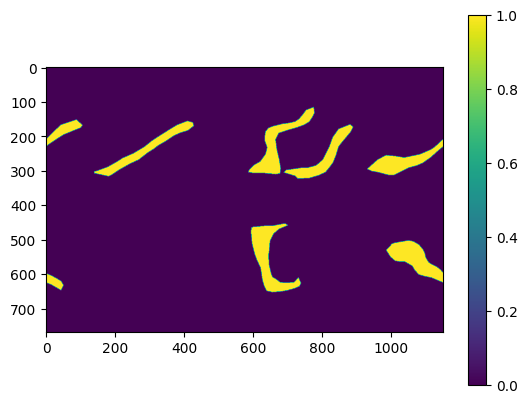

In [12]:
gt_mask = true_mask[10,0,:,:]

plt.imshow(gt_mask)
plt.colorbar()

In [14]:
import torch
import numpy as np
from climatenet.procrustes_loss import ProcrustesLoss

# Instantiate the loss function.
loss_fn = ProcrustesLoss(threshold=0.8, allow_scaling=True, penalty_constant=1000)

# Create a dummy ground truth mask: shape [B, 1, H, W]
# For instance, a square region with value 1 and background 0.
gt_mask_np = np.zeros((1, 1, 64, 64), dtype=np.float32)
gt_mask_np[0, 0, 20:40, 20:40] = 1

# Create a dummy predicted probability map:
# Here, we simulate a predicted region that is shifted relative to the ground truth.
pred_proba_np = np.zeros((1, 1, 64, 64), dtype=np.float32)
pred_proba_np[0, 0, 25:45, 25:45] = 0.9

# Convert to torch tensors.
gt_tensor = torch.tensor(gt_mask_np)
pred_tensor = torch.tensor(pred_proba_np)

# Compute the loss (with debug output enabled).
loss_value, debug_info = loss_fn(pred_tensor, gt_tensor, debug=True)
print("Loss value:", loss_value.item())

# Optionally, inspect the debug information (e.g., loss map, distance transforms).
print("Debug info:", debug_info)


Loss value: 0.8701171278953552
Debug info: {'loss_field': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'dt_gt': tensor([[28.2843, 27.5862, 26.9072,  ..., 29.7321, 30.4795, 31.2410],
        [27.5862, 26.8701, 26.1725,  ..., 29.0689, 29.8329, 30.6105],
        [26.9072, 26.1725, 25.4558,  ..., 28.4253, 29.2062, 30.0000],
        ...,
        [29.7321, 29.0689, 28.4253,  ..., 31.1127, 31.8277, 32.5576],
        [30.4795, 29.8329, 29.2062,  ..., 31.8277, 32.5269, 33.2415],
        [31.2410, 30.6105, 30.0000,  ..., 32.5576, 33.2415, 33.9411]],
       dtype=torch.float64), 'dt_final_custom': tensor([[28.2843, 27.5862, 26.9072,  ..., 29.7321, 30.4795, 31.2410],
        [27.5862, 26.8701, 26.1725,  ..., 29.0689, 29.8329, 30.6105],
        [26.9072, 26.1725, 25.4558,  ..., 28.425

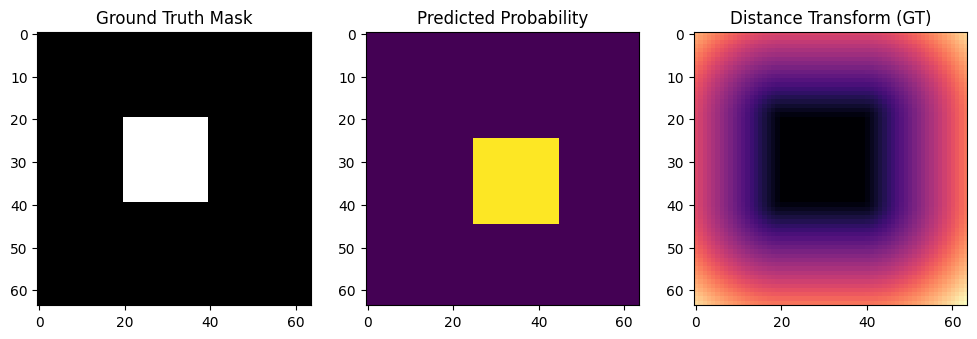

In [15]:
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

# Convert ground truth and prediction to boolean masks.
gt_mask_bool = gt_mask_np[0, 0].astype(bool)
pred_mask_bool = (pred_proba_np[0, 0] >= 0.8)

# Compute the distance transform for the ground truth.
dt_gt = distance_transform_edt(~gt_mask_bool)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gt_mask_np[0, 0], cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(1, 3, 2)
plt.imshow(pred_proba_np[0, 0], cmap='viridis')
plt.title('Predicted Probability')
plt.subplot(1, 3, 3)
plt.imshow(dt_gt, cmap='magma')
plt.title('Distance Transform (GT)')
plt.show()


Loss value: 9324.6962890625


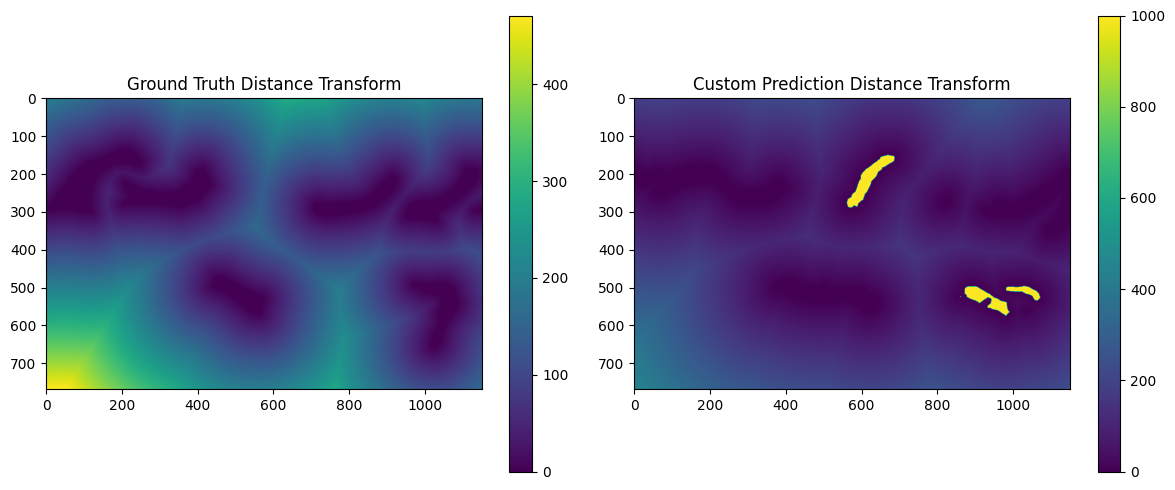

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from climatenet.procrustes_loss import ProcrustesLoss  # assuming you saved the above in procrustes_loss.py

# Instantiate the loss function.
loss_fn = ProcrustesLoss(threshold=0.8, allow_scaling=False, penalty_constant=1000)

# Create synthetic data.
# Let's create a dummy ground truth mask: a square in the center.
gt_mask_np = np.zeros((1, 1, 64, 64), dtype=np.float32)
gt_mask_np[0, 0, 0:20, 20:40] = 1

# Create a predicted probability map that is shifted.
pred_proba_np = np.zeros((1, 1, 64, 64), dtype=np.float32)
pred_proba_np[0, 0, 20:40, 20:40] = 0.9

gt_mask_np = true_mask[0:1,:,:,:]
pred_proba_np = predictions[0:1,2:3,:,:]


# Convert to torch tensors.
gt_tensor = torch.tensor(gt_mask_np)
pred_tensor = torch.tensor(pred_proba_np)

# Call the loss function in debug mode.
loss_val, debug_info = loss_fn(pred_tensor, gt_tensor, debug=True)
print("Loss value:", loss_val.item())

# Extract distance transforms.
dt_gt = debug_info['dt_gt'].detach().cpu().numpy()
dt_final_custom = debug_info['dt_final_custom'].detach().cpu().numpy()

# Plot the distance transforms.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(dt_gt, cmap='viridis')
plt.title('Ground Truth Distance Transform')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(dt_final_custom, cmap='viridis')
plt.title('Custom Prediction Distance Transform')
plt.colorbar()

plt.tight_layout()
plt.show()


In [15]:
# Compute the squared error:
pred_error = (gt_tensor - pred_tensor) ** 2

# Weight the error by the sum of the distance transforms raised to the alpha power:
distance_weight = dt_gt ** 2 + dt_final_custom ** 2

# Compute the final error map:
error_map = pred_error * distance_weight

In [16]:
error_map = np.array(error_map)

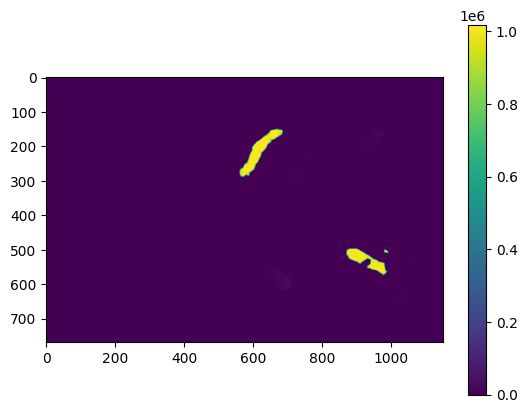

In [17]:
plt.imshow(error_map.squeeze())
plt.colorbar()


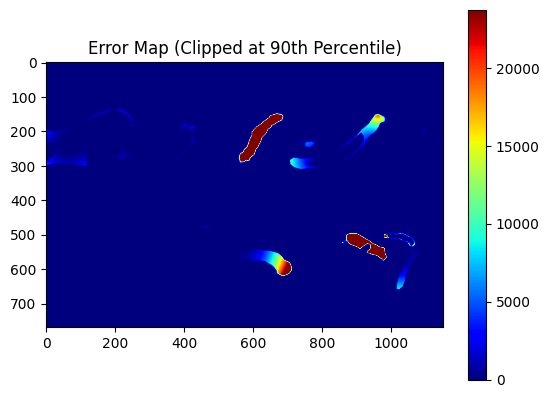

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Assume error_map is a torch tensor; squeeze and convert to NumPy.
error_map_np = error_map.squeeze().detach().cpu().numpy()

# Compute the 90th percentile (i.e. the value below which 90% of the data lies)
p90 = np.percentile(error_map_np, 99)

# Clip the error map: values above the 90th percentile are set to the 90th percentile.
error_map_clipped = np.clip(error_map_np, a_min=None, a_max=p90)

# Plot the clipped error map
plt.imshow(error_map_clipped, cmap='jet')
plt.colorbar()
plt.title("Error Map (Clipped at 90th Percentile)")
plt.show()


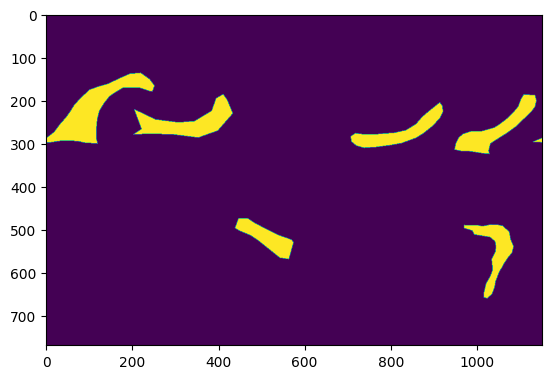

In [71]:
plt.imshow(gt_tensor.squeeze())

<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

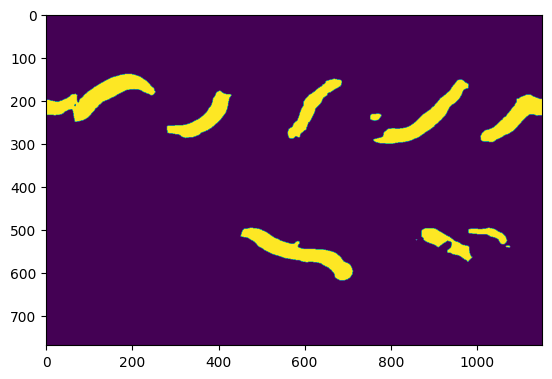

In [45]:
plt.imshow(pred_tensor.squeeze()>0.8)
plt.colorbar

In [31]:
predictions[0:1,0:1,:,:].shape

(1, 1, 768, 1152)

In [44]:
import numpy as np
import torch
from monai.losses.hausdorff_loss import HausdorffDTLoss  # or your custom HausdorffDTLoss if defined

# Assume true_mask and predictions are your NumPy arrays.
# For example, they might have shapes:
#   true_mask:   (B, C, H, W)  e.g. (8, 3, 768, 1152)
#   predictions: (B, C, H, W)  e.g. (8, 3, 768, 1152)

# Slice out a single sample:
gt_mask_np = true_mask[0:1, :, :, :]        # Keep batch dimension (1, C, H, W)
pred_proba_np = predictions[0:1, 2:3, :, :]   # Select channel 2 as prediction, keeping dims

# Convert to torch tensors:
gt_mask_tensor = torch.from_numpy(gt_mask_np).float()
pred_tensor = torch.from_numpy(pred_proba_np).float()

# Instantiate the HausdorffDTLoss.
# (Here we set sigmoid=True to apply a sigmoid activation on pred_tensor.)
loss_fn = HausdorffDTLoss(
    alpha=2.0,
    include_background=False,
    to_onehot_y=False,
    sigmoid=False,    # If your predictions are logits, this will convert them to probabilities.
    softmax=False,
    reduction="mean",
    batch=False
)

# Compute the loss.
loss = loss_fn(pred_tensor, gt_mask_tensor)
print("Hausdorff Loss:", loss.item())


Hausdorff Loss: 187.9410400390625


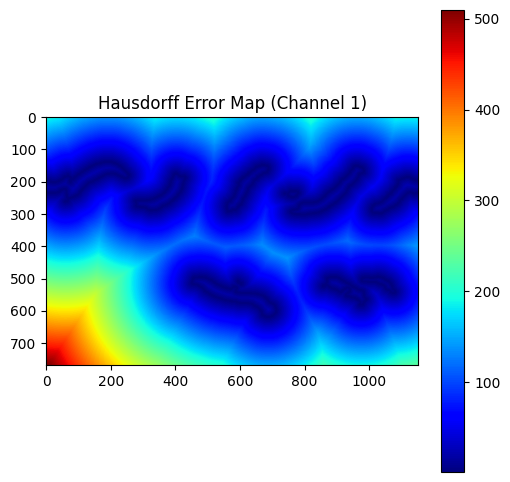

In [56]:
import torch
import matplotlib.pyplot as plt
from monai.losses.hausdorff_loss import HausdorffDTLoss  # or your custom implementation

# For this example, assume that:
# - input: torch.Tensor of shape [B, C, H, W] (logits or probabilities)
# - target: torch.Tensor of shape [B, C, H, W] or [B, H, W] (one-hot or binary mask)
#
# We select one sample (batch index 0) and one channel (e.g., channel 1) for visualization.
# Here we assume the prediction is already a probability map so we set sigmoid=False.

# Dummy example tensors (replace with your actual tensors)
B, C, H, W = 1, 3, 256, 256  # adjust dimensions as needed
# Create dummy prediction and target tensors:
pred = torch.rand(B, C, H, W)  # predicted probability map for each class
target = (torch.rand(B, C, H, W) > 0.5).float()  # binary ground truth in one-hot style

# Slice out one sample and one channel (e.g., channel 1)
ch_input = true_mask[0:1, :, :, :]  # shape: [B, 1, H, W]
ch_target = predictions[0:1, 2:3, :, :]

# Convert to torch tensors:
ch_input = torch.from_numpy(gt_mask_np).float()
ch_target = torch.from_numpy(pred_proba_np).float()


# Instantiate the Hausdorff loss function.
loss_fn = HausdorffDTLoss(
    alpha=2.0,
    include_background=False,
    to_onehot_y=False,
    sigmoid=False,   # predictions are assumed to be probabilities already
    softmax=False,
    reduction="none",  # we want to see per-pixel values
    batch=False
)

# Compute the distance transforms and error map for this channel.
# First, detach and compute distance transforms:
pred_dt = torch.from_numpy(loss_fn.distance_field(ch_input).cpu().numpy()).float()
target_dt = torch.from_numpy(loss_fn.distance_field(ch_target).cpu().numpy()).float()

# Compute the squared error:
pred_error = (ch_input - ch_target) ** 2

# Weight the error by the sum of the distance transforms raised to the alpha power:
distance_weight = pred_dt ** loss_fn.alpha + target_dt ** loss_fn.alpha

# Compute the final error map:
error_map = pred_error * distance_weight.to(ch_input.device)

# Convert the error map to NumPy for visualization:
# error_map_np = error_map[0, 0].detach().cpu().numpy()  # selecting first sample and channel

# Plot the error map:
plt.figure(figsize=(6, 6))
plt.imshow(target_dt.squeeze(), cmap='jet')
plt.colorbar()
plt.title("Hausdorff Error Map (Channel 1)")
plt.show()


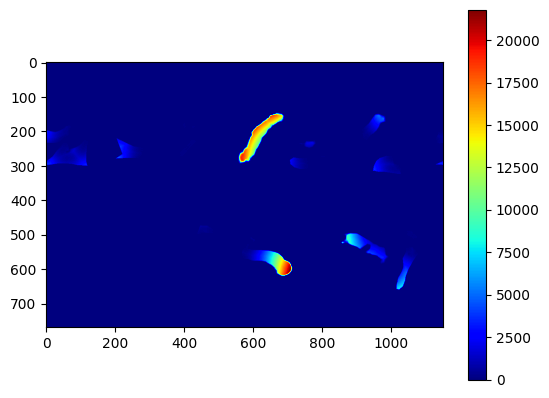

In [60]:
plt.imshow(error_map.squeeze(), cmap='jet')
plt.colorbar()

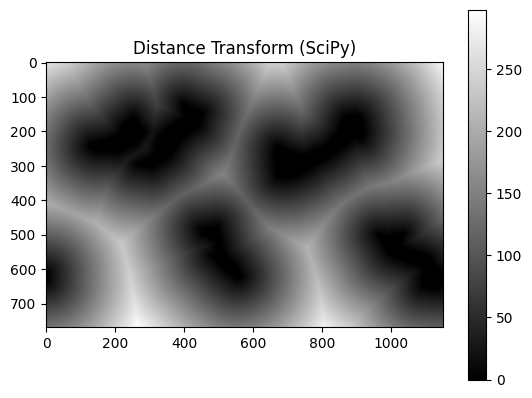

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

# Assume gt_mask is a boolean or binary array where foreground is True (or 1)
# If necessary, ensure gt_mask is boolean:
gt_mask_bool = gt_mask.astype(bool)

# Compute the distance transform from the background to the nearest foreground pixel.
# Here, we invert the mask: background becomes True (to compute distances from background to object)
dt = distance_transform_edt(~gt_mask_bool)

# Plot the resulting distance map
plt.imshow(dt, cmap='gray')
plt.title('Distance Transform (SciPy)')
plt.colorbar()
plt.show()


In [159]:
np.unique(gt_mask)

array([0, 1])

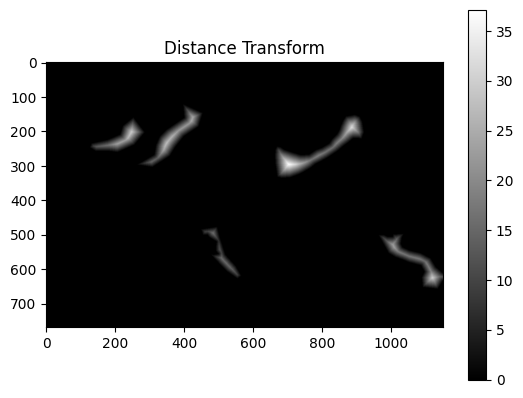

In [163]:
import cv2 as cv
gt_mask_uint8 = (gt_mask.astype(np.uint8)) * 255

# Compute the distance transform
# cv.DIST_L2 is the Euclidean distance and 3 is the mask size (3x3)
dist = cv.distanceTransform(gt_mask_uint8, cv.DIST_L2, 3)

# Plot the distance transform
plt.imshow(dist, cmap='gray')
plt.title('Distance Transform')
plt.colorbar()
plt.show()

In [75]:
# B) Extract boundaries
gt_boundaries = label_and_extract_boundaries(gt_mask)
# pred_boundaries = label_and_extract_boundaries(pred_mask)
    
#     # C) Match
# assignments = match_objects(gt_boundaries, pred_boundaries)
    

In [93]:
assignments

[(1, 2, 12.070429),
 (2, 5, 13.883512),
 (3, 6, 19.910938),
 (4, 13, 42.227467),
 (5, 12, 20.444088),
 (6, 1, 471.68365)]

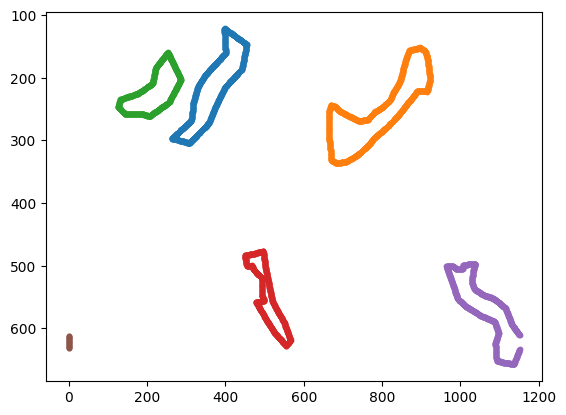

In [85]:
for contour_id, contour_points in gt_boundaries:
    # Scatter plot of each contour
    plt.scatter(contour_points[:, 1], contour_points[:, 0], label=f'Contour {contour_id}', s=10)
plt.gca().invert_yaxis()
    

In [13]:
predictions.shape

(61, 3, 768, 1152)

In [ ]:
plt.imshow(true_mask[60,0,:,:])
plt.colorbar()


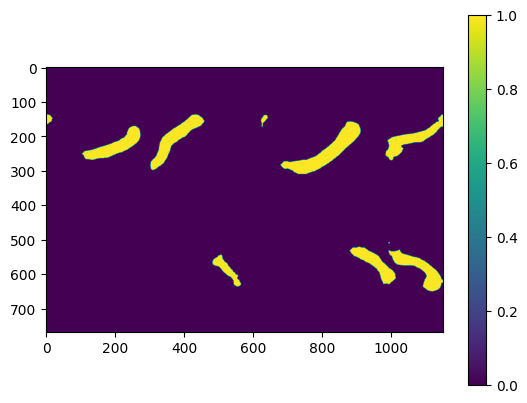

In [171]:
plt.imshow(predictions[60,2,:,:]>0.8)
plt.colorbar()


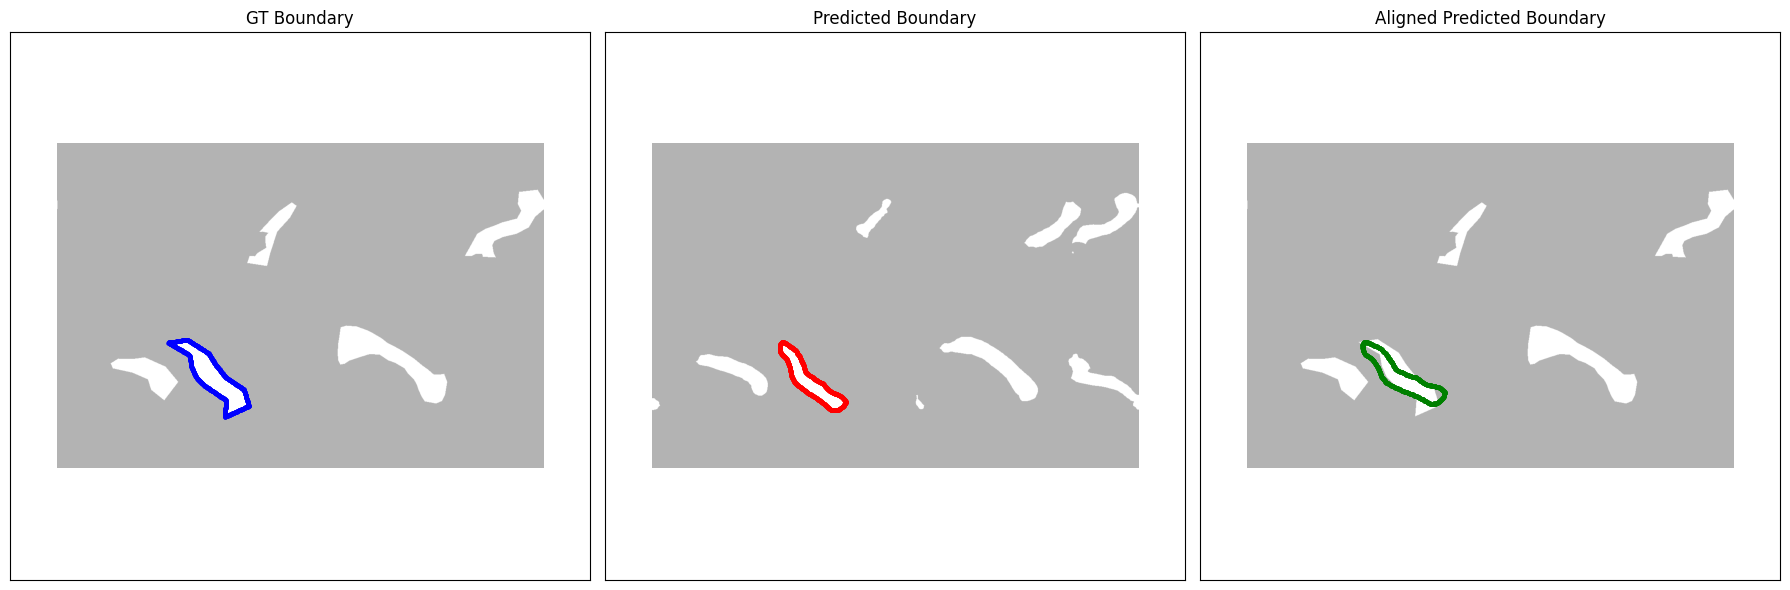

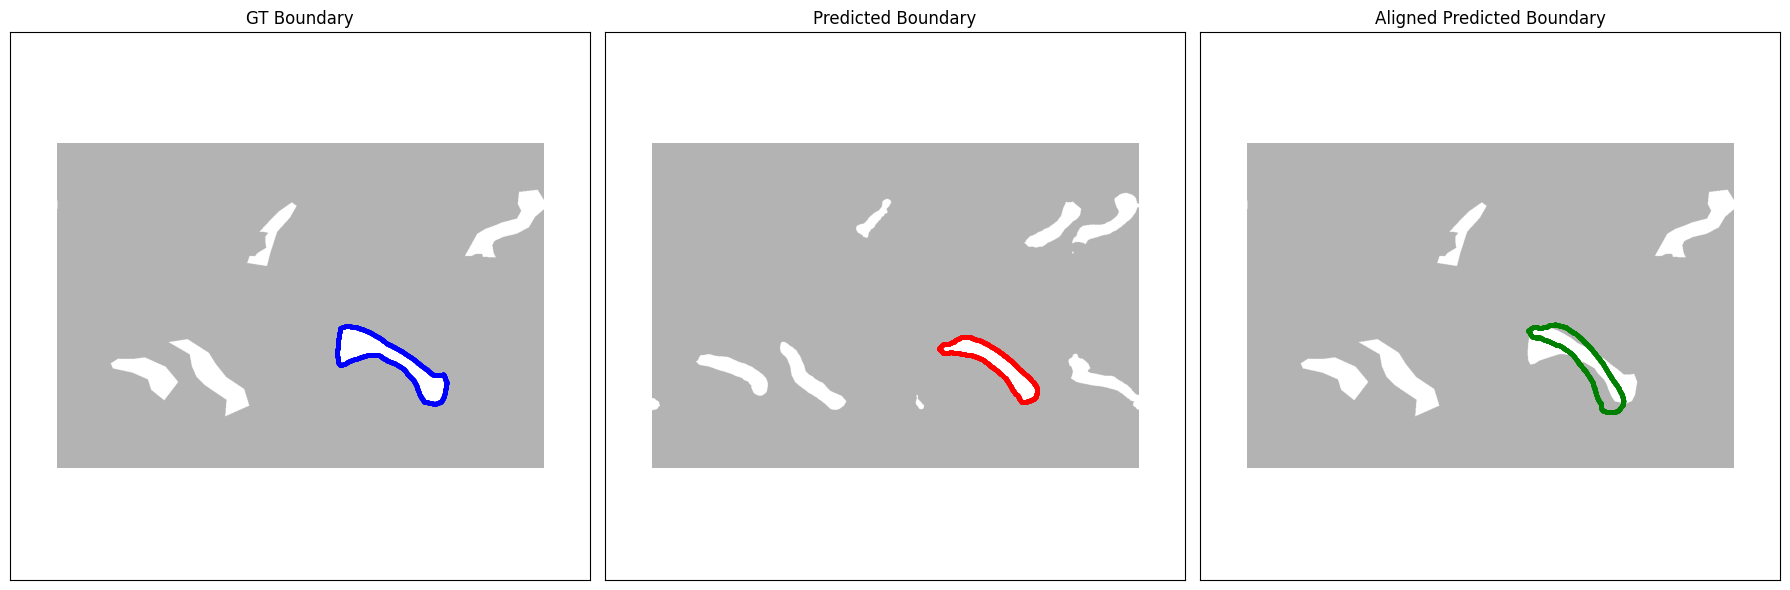

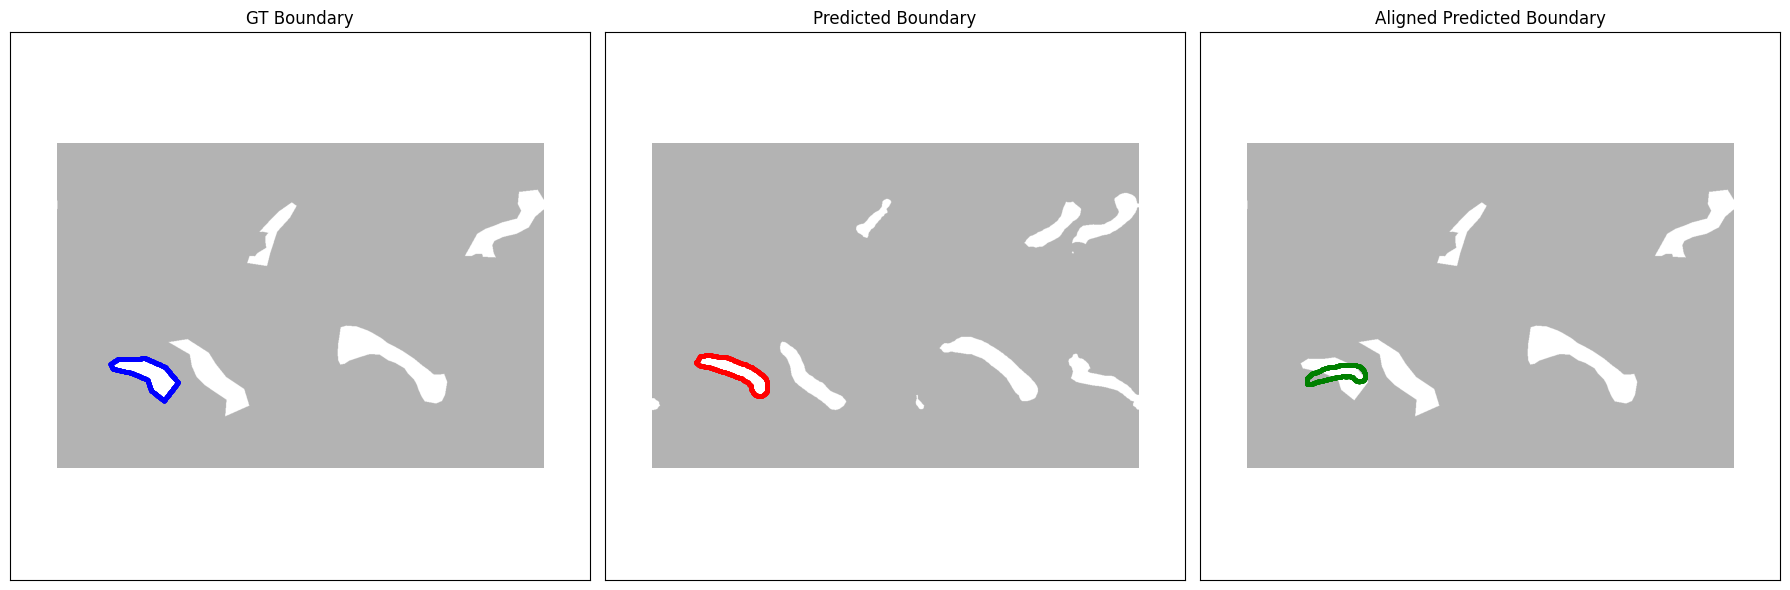

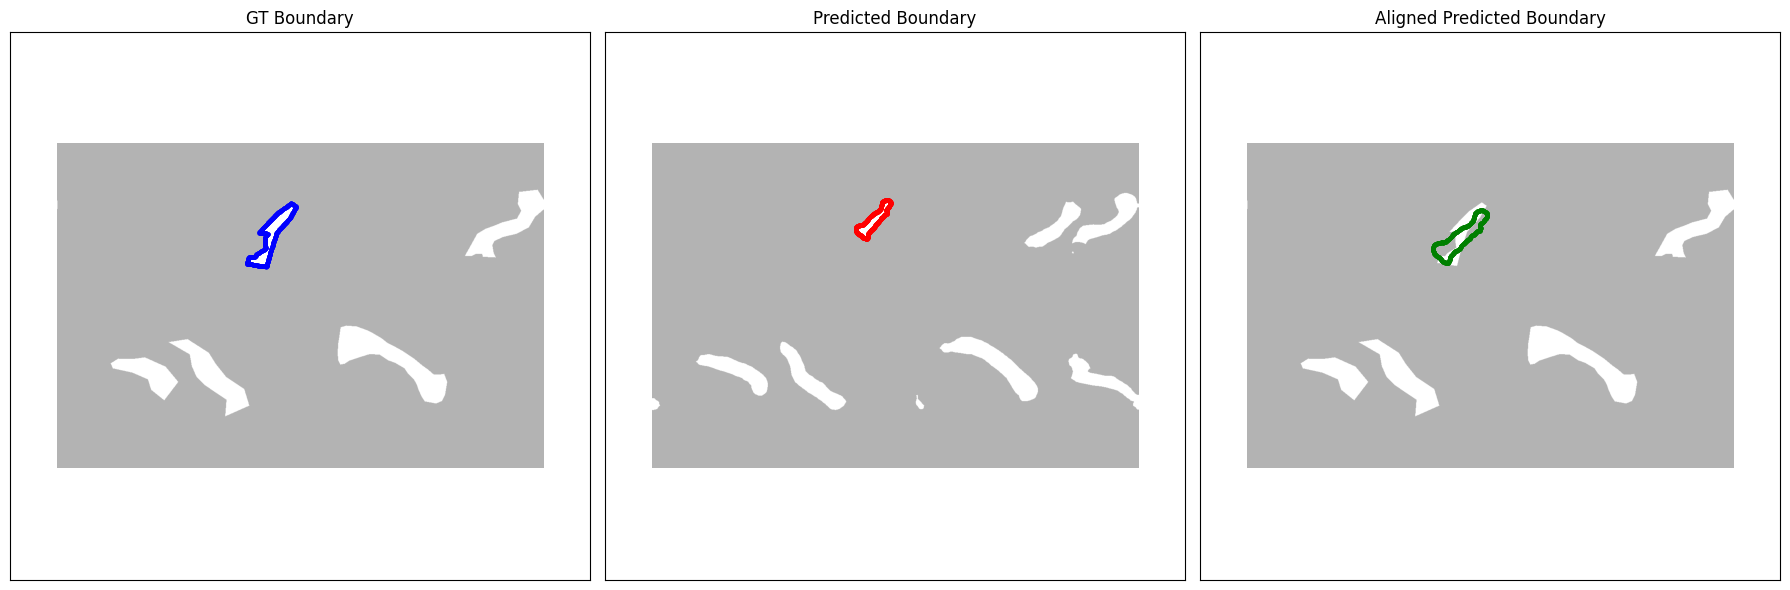

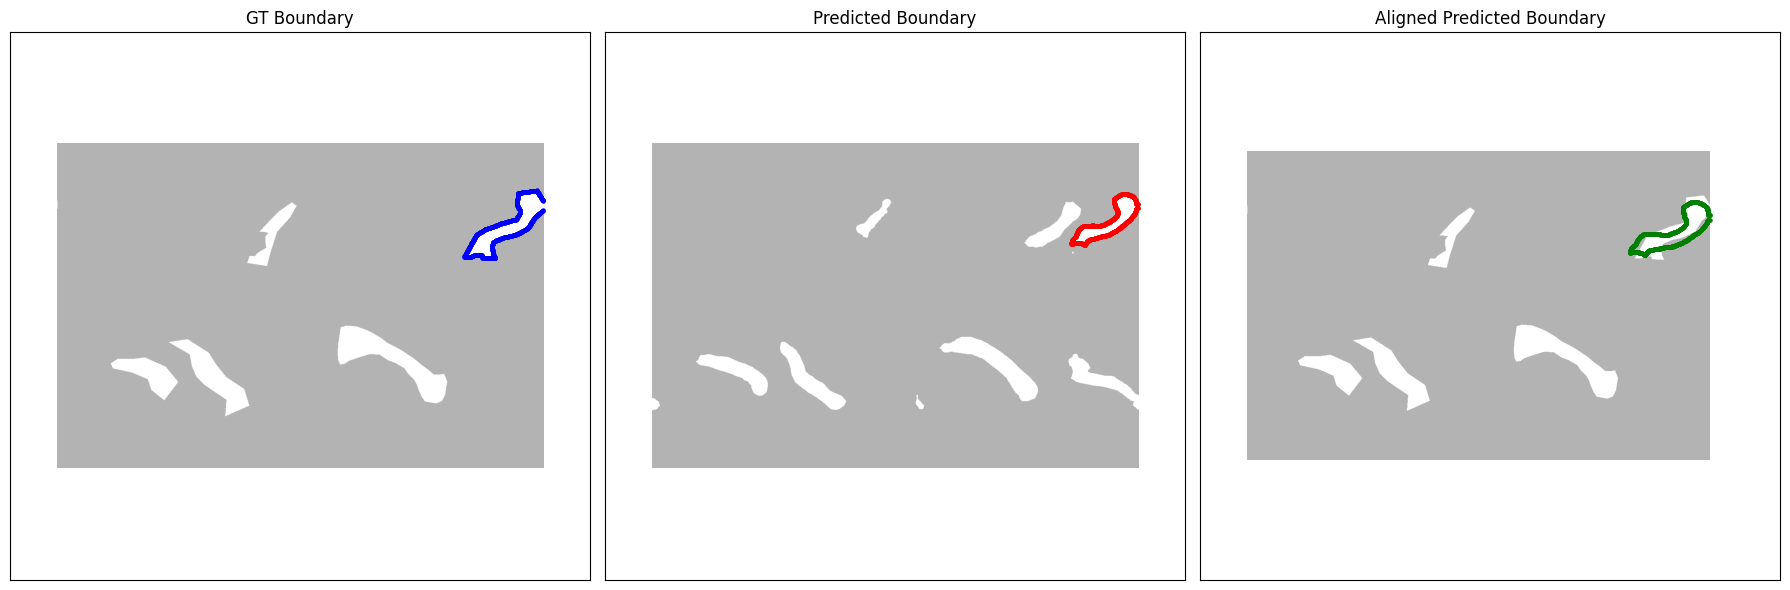

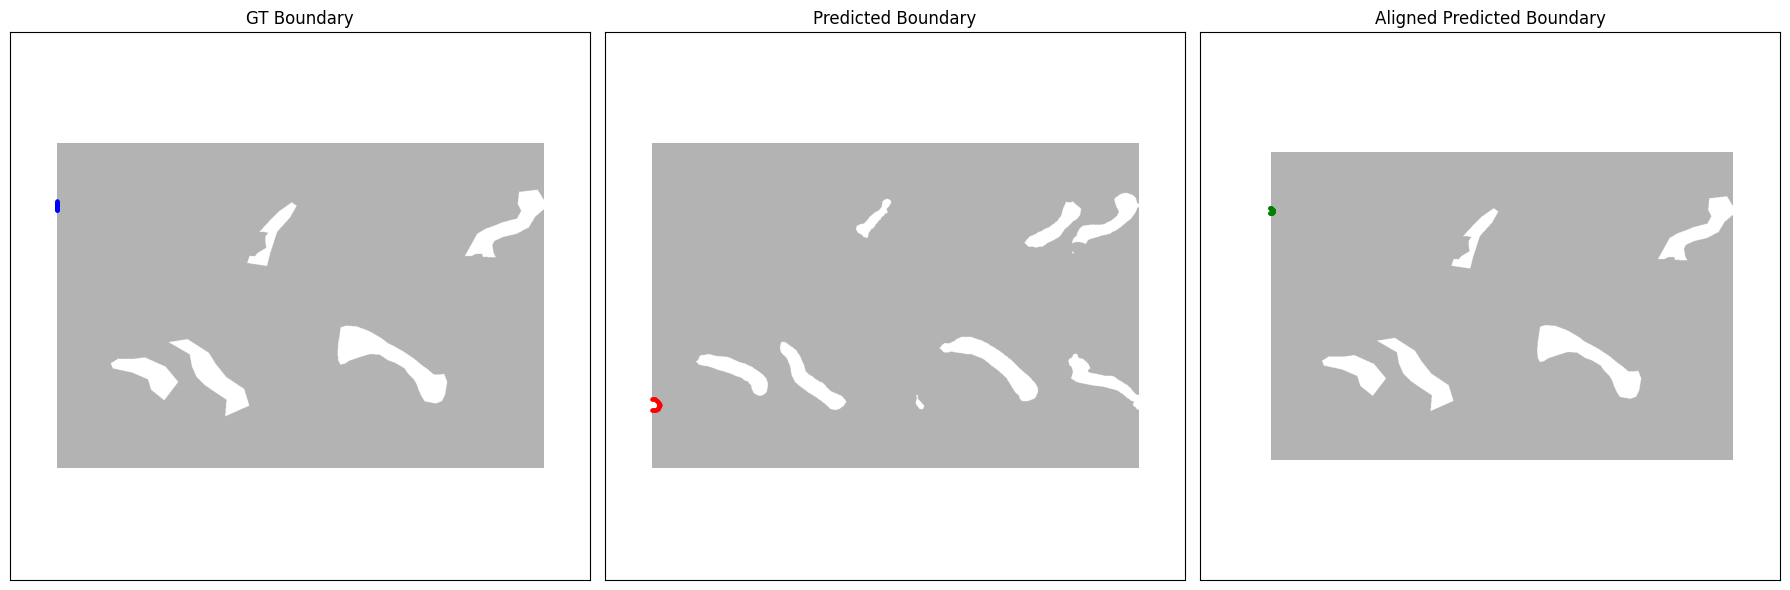

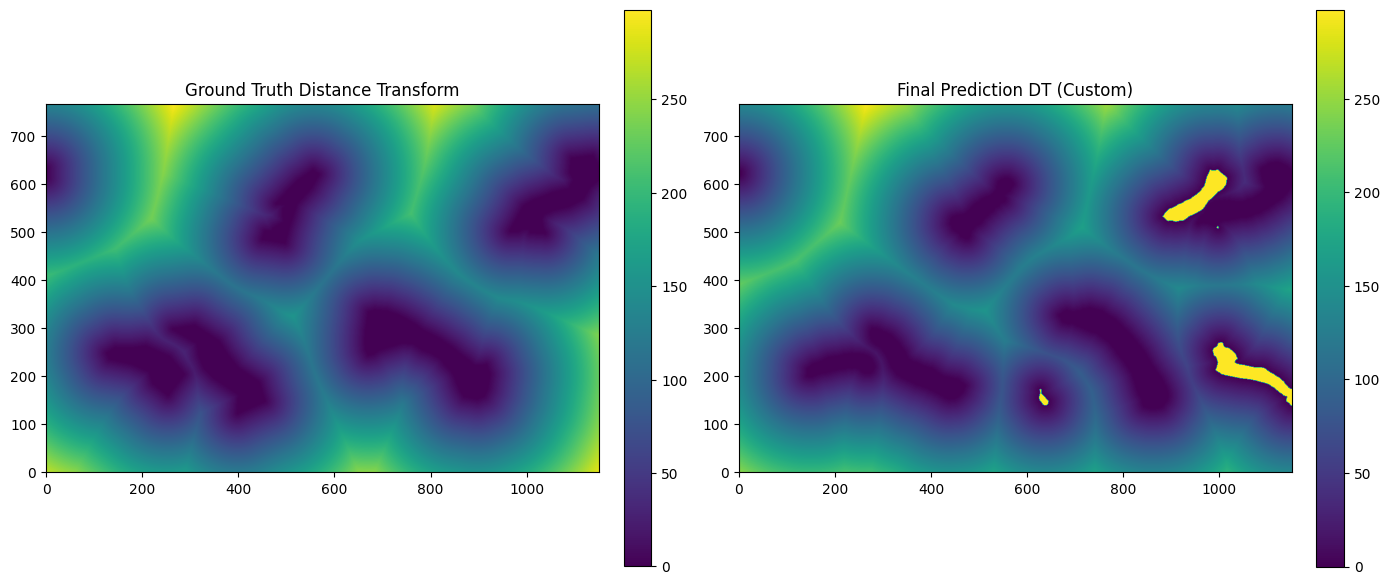

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[269.5347844 , 269.04646439, 268.56098004, ..., 286.50479926,
         287.33952043, 288.17529388],
        [268.66335813, 268.17345133, 267.68638367, ..., 285.95454184,
         286.79086457, 287.62823227],
        [267.79283037, 267.30132809, 266.81266836, ..., 285.40672732,
         286.24465061, 287.08361151],
        ...,
        [134.        , 134.00373129, 134.01492454, ..., 108.77959367,
         108.90362712, 109.03669107],
        [135.        , 135.00370365, 135.014814  , ..., 109.772492  ,
         109.89540482, 110.02726935],
        [136.        , 136.00367642, 136.01470509, ..., 110.7655181 ,
         110.8873302

In [16]:
pipeline(true_mask[60,0,:,:], predictions[60,2,:,:])

In [ ]:
class CustomLoss:
    def __init__(self, threshold=0.8, allow_scaling=True):
        """
        Initialize the loss function.
        
        Parameters:
         - threshold: the threshold to binarize the prediction probabilities.
         - allow_scaling: whether to allow scaling during Procrustes alignment.
        """
        self.threshold = threshold
        self.allow_scaling = allow_scaling

    def __call__(self, gt_mask, pred_proba):
        """
        Compute the loss given the ground truth mask and predicted probabilities.
        
        Parameters:
         - gt_mask: 2D numpy array (binary) for the ground truth.
         - pred_proba: 2D numpy array with prediction probabilities.
        
        Returns:
         - loss: the mean loss (a scalar).
         - loss_map: the pixel-wise loss map.
        """
        # Run your pipeline which returns:
        # final_pred_mask: the final prediction mask (after aligning assigned objects and leaving unassigned ones intact)
        # dt_gt: distance transform of the ground truth mask (computed as edt on the inverse of gt_mask)
        # dt_final_custom: customized distance transform for the prediction,
        #                  where pixels in unassigned objects are set to a high penalty.
        final_pred_mask, dt_gt, dt_final_custom = pipeline(gt_mask, pred_proba, 
                                                           threshold=self.threshold, 
                                                           allow_scaling=self.allow_scaling)
        
        # Compute the squared error pixel-wise between the ground truth mask and prediction probabilities.
        error = (gt_mask.astype(np.float32) - pred_proba)**2
        
        # Define a weight map using the squared distance transforms.
        # Here we use the sum of squared distances from the ground truth and the customized prediction DT.
        weight = dt_gt**2 + dt_final_custom**2
        
        # Compute the pixel-wise loss map.
        loss_map = error * weight
        
        # Return the mean loss and the per-pixel loss map.
        loss = loss_map.mean()
        return loss, loss_map

# Example usage:
# loss_fn = CustomLoss(threshold=0.8, allow_scaling=True)
# loss_value, loss_map = loss_fn(gt_mask, pred_proba)
# print("Loss:", loss_value)


In [10]:
batch_size = true_mask.shape[0]

for b in range(batch_size):
    # Extract a single 2D ground-truth mask
    # e.g. if true_mask is (B,1,H,W), do:
    gt_2d = true_mask[b, 0,:,:].squeeze()
    print(gt_2d.shape) # shape (H,W)

    # Extract the predicted probability for class=2, shape (H,W)
    pred_2d = predictions[b, 2,:,:].squeeze()
    print(pred_2d.shape)

    # Now call the pipeline
    results = pipeline(gt_2d, pred_2d, threshold=0.5, allow_scaling=True)
    print("Batch index:", b, " => ", results)


(768, 1152)
(768, 1152)
Batch index: 0  =>  [{'gt_id': 1, 'pred_id': 1, 'assignment_cost': 19.550508, 'hausdorff_distance': 1}, {'gt_id': 2, 'pred_id': 4, 'assignment_cost': 43.870644, 'hausdorff_distance': 1}, {'gt_id': 3, 'pred_id': 3, 'assignment_cost': 171.18697, 'hausdorff_distance': 1}, {'gt_id': 4, 'pred_id': 6, 'assignment_cost': 68.75542, 'hausdorff_distance': 1}, {'gt_id': 5, 'pred_id': 5, 'assignment_cost': 79.89779, 'hausdorff_distance': 1}, {'gt_id': 6, 'pred_id': 8, 'assignment_cost': 83.80603, 'hausdorff_distance': 1}, {'gt_id': 7, 'pred_id': 9, 'assignment_cost': 41.78321, 'hausdorff_distance': 1068.5253857536563}]
(768, 1152)
(768, 1152)
Batch index: 1  =>  [{'gt_id': 1, 'pred_id': 1, 'assignment_cost': 65.621605, 'hausdorff_distance': 1}, {'gt_id': 2, 'pred_id': 3, 'assignment_cost': 14.39715, 'hausdorff_distance': 1}, {'gt_id': 3, 'pred_id': 4, 'assignment_cost': 7.339667, 'hausdorff_distance': 1}, {'gt_id': 4, 'pred_id': 11, 'assignment_cost': 428.3145, 'hausdorff_d

In [38]:
label_and_extract_boundaries(true_mask[60,0,:,:])

[(1,
  array([[304.5, 308. ],
         [304. , 307.5],
         [303.5, 307. ],
         ...,
         [303.5, 309. ],
         [304. , 308.5],
         [304.5, 308. ]])),
 (2,
  array([[336.5, 684. ],
         [336. , 683.5],
         [335.5, 683. ],
         ...,
         [335.5, 685. ],
         [336. , 684.5],
         [336.5, 684. ]])),
 (3,
  array([[261.5, 207. ],
         [261. , 206.5],
         [260.5, 206. ],
         ...,
         [260.5, 208. ],
         [261. , 207.5],
         [261.5, 207. ]])),
 (4,
  array([[627.5, 555. ],
         [627. , 554.5],
         [626.5, 554. ],
         ...,
         [626.5, 556. ],
         [627. , 555.5],
         [627.5, 555. ]])),
 (5,
  array([[ 633.5, 1151. ],
         [ 634. , 1150.5],
         [ 635. , 1150.5],
         ...,
         [ 609.5, 1150. ],
         [ 610. , 1150.5],
         [ 610.5, 1151. ]])),
 (6,
  array([[6.115e+02, 0.000e+00],
         [6.120e+02, 5.000e-01],
         [6.130e+02, 5.000e-01],
         [6.140e+02, 5.0

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, find_contours
from scipy.optimize import linear_sum_assignment

############################################
# 1. Utility: Extract boundaries from a single-object mask
############################################
def get_all_boundary_points(mask, level=0.5):
    """
    Extract all boundary points from a binary mask by finding all contours
    and concatenating them into one array.
    Returns None if no contour is found.
    """
    contours = find_contours(mask, level=level)
    if len(contours) == 0:
        return None
    all_points = np.vstack(contours)
    return all_points

############################################
# 2. Label GT and predicted masks
############################################
def process_masks(true_mask, pred_mask, max_distance_threshold=50):
    """
    - Label each connected component in true_mask and pred_mask.
    - Assign each GT object to the best predicted object via Hungarian.
    - Build a new predicted mask containing ONLY assigned predicted objects.
    - Return that “filtered” predicted mask plus assignment info.
    
    true_mask: shape (H, W) binary
    pred_mask: shape (H, W) binary
    """
    # Label each
    labeled_true = label(true_mask, connectivity=2)
    labeled_pred = label(pred_mask, connectivity=2)

    true_props = regionprops(labeled_true)
    pred_props = regionprops(labeled_pred)

    # Centroids
    true_centroids = np.array([prop.centroid for prop in true_props])
    true_labels = np.array([prop.label for prop in true_props])
    
    pred_centroids = np.array([prop.centroid for prop in pred_props])
    pred_labels = np.array([prop.label for prop in pred_props])

    # If no objects in GT or pred, handle gracefully
    if len(true_labels) == 0 or len(pred_labels) == 0:
        print("No objects found in GT or Pred. Returning empty assigned mask.")
        assigned_mask = np.zeros_like(true_mask)
        return assigned_mask, []

    # Build cost matrix: Euclidean distance between GT and pred centroids
    cost_matrix = np.linalg.norm(true_centroids[:, None, :] - pred_centroids[None, :, :], axis=2)

    # Hungarian assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Create an empty mask to hold only assigned predicted objects
    assigned_pred_mask = np.zeros_like(pred_mask)

    assignments = []
    for i, j in zip(row_ind, col_ind):
        dist = cost_matrix[i, j]
        if dist <= max_distance_threshold:
            # This predicted object is assigned
            gt_lbl = true_labels[i]
            pr_lbl = pred_labels[j]
            assignments.append((gt_lbl, pr_lbl, dist))

            # Put that predicted object into the assigned_pred_mask
            assigned_pred_mask[labeled_pred == pr_lbl] = 1
        else:
            print(f"Skipping GT object {true_labels[i]} - centroid distance {dist:.2f} > threshold")

    return assigned_pred_mask, assignments

In [49]:
true_mask1 = true_mask[60,0,:,:]

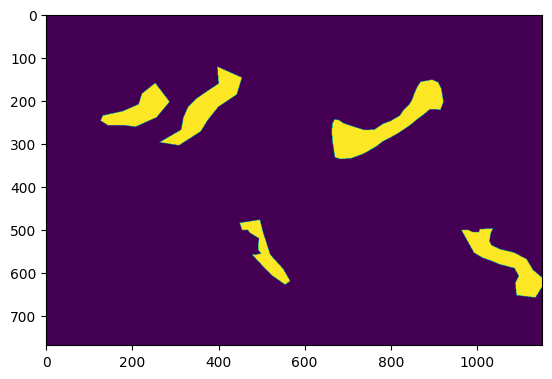

In [60]:
plt.imshow(true_mask1)

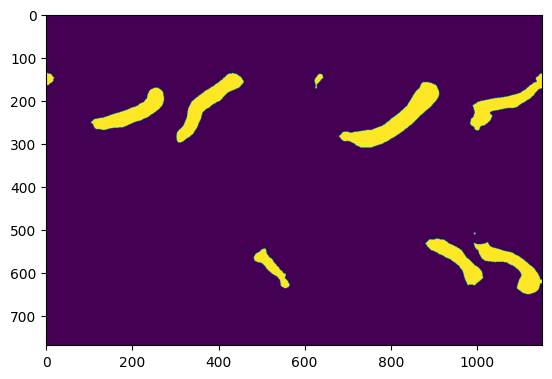

In [59]:
plt.imshow(pred_mask1)

In [58]:
pred_prob1 = predictions[60,2,:,:]

In [57]:
pred_mask1 = pred_prob1>0.8

In [62]:
true_b1 = label_and_extract_boundaries(true_mask1)

In [63]:
pred_b1 = label_and_extract_boundaries(pred_mask1)

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def plot_boundaries(gt_obj, pr_obj, gt_pts, pr_pts):
    """
    Plot the ground-truth object mask and predicted object mask, 
    plus their boundary points (gt_pts, pr_pts).
    
    gt_obj: 2D np.array (bool or 0/1)
    pr_obj: 2D np.array (bool or 0/1)
    gt_pts: (N,2) array of [row,col] for GT boundary
    pr_pts: (M,2) array of [row,col] for Pred boundary
    """
    # Combine both objects to see them side by side in a single figure
    combined = np.maximum(gt_obj, pr_obj)
    
    plt.figure(figsize=(6,6))
    plt.imshow(combined, cmap='gray', alpha=0.7)
    
    # Plot GT boundary in red
    if gt_pts is not None:
        plt.plot(gt_pts[:,1], gt_pts[:,0], 'r-', lw=2, label='GT Boundary')
        plt.scatter(gt_pts[:,1], gt_pts[:,0], c='red', s=10)
    
    # Plot Pred boundary in blue
    if pr_pts is not None:
        plt.plot(pr_pts[:,1], pr_pts[:,0], 'b-', lw=2, label='Pred Boundary')
        plt.scatter(pr_pts[:,1], pr_pts[:,0], c='blue', s=10)
    
    plt.title("GT vs. Pred Boundaries")
    plt.legend()
    plt.axis("off")
    plt.show()

TypeError: list indices must be integers or slices, not tuple

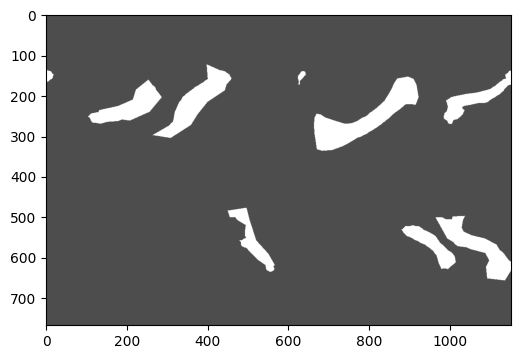

In [71]:
plot_boundaries(true_mask1,pred_mask1, true_b1, pred_b1)

Number of final contours: 2


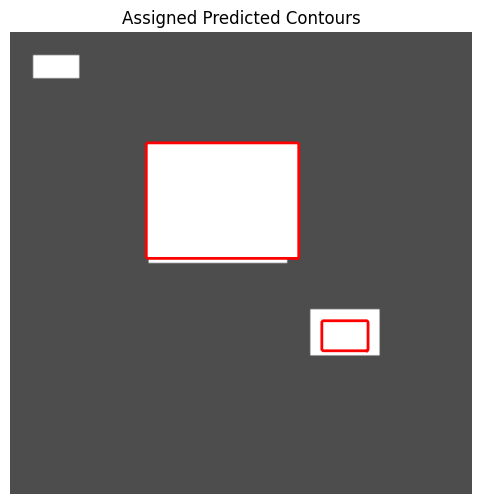

In [72]:
import numpy as np
from skimage.measure import label, regionprops, find_contours
from scipy.optimize import linear_sum_assignment

def filter_pred_contours_by_assignment(true_mask, pred_mask, max_dist=50):
    """
    Keep only the predicted contours that have a matching (assigned) object in the true image.
    
    1) Label both GT and pred masks.
    2) Match each GT object to the nearest predicted object by centroid distance (Hungarian).
    3) Collect the assigned predicted object labels (within max_dist).
    4) Build an 'assigned_pred_mask' with only those assigned objects.
    5) Extract contours from 'assigned_pred_mask' and return them.
    
    Parameters:
      true_mask (np.array): 2D binary array for ground-truth.
      pred_mask (np.array): 2D binary array for predicted.
      max_dist (float): Max centroid distance threshold for valid assignment.
    
    Returns:
      final_contours (list of np.array): Each array is shape (N,2) of boundary coords (row,col).
                                         These correspond only to predicted objects that got assigned.
    """
    # 1) Label GT & predicted
    labeled_true = label(true_mask, connectivity=2)
    labeled_pred = label(pred_mask, connectivity=2)

    # 2) regionprops to get centroid info
    t_props = regionprops(labeled_true)
    p_props = regionprops(labeled_pred)
    
    if len(t_props) == 0 or len(p_props) == 0:
        # No objects in GT or Pred => no assignment
        return []

    # build cost matrix of centroid distances
    t_centroids = np.array([prop.centroid for prop in t_props])
    p_centroids = np.array([prop.centroid for prop in p_props])
    cost_matrix = np.linalg.norm(
        t_centroids[:, None, :] - p_centroids[None, :, :],
        axis=2
    )
    # Hungarian assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # 3) Collect assigned predicted labels
    assigned_pred_labels = set()
    for i, j in zip(row_ind, col_ind):
        dist = cost_matrix[i, j]
        if dist <= max_dist:
            assigned_pred_labels.add(p_props[j].label)

    # 4) Build assigned predicted mask
    assigned_pred_mask = np.zeros_like(pred_mask, dtype=bool)
    for lbl in assigned_pred_labels:
        assigned_pred_mask[labeled_pred == lbl] = True

    # 5) Extract contours from assigned_pred_mask
    final_contours = find_contours(assigned_pred_mask, level=0.5)
    return final_contours

# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    # Simple demonstration
    H, W = 200, 200
    true_mask = np.zeros((H,W), dtype=bool)
    true_mask[50:100, 60:120] = True  # object1
    true_mask[120:140, 130:160] = True # object2

    pred_mask = np.zeros((H,W), dtype=bool)
    pred_mask[48:98, 59:125] = True    # near object1
    pred_mask[125:138, 135:155] = True # near object2
    pred_mask[10:20, 10:30] = True     # extra object, unassigned

    final_contours = filter_pred_contours_by_assignment(true_mask, pred_mask, max_dist=30)
    print(f"Number of final contours: {len(final_contours)}")

    # Plot
    plt.figure(figsize=(6,6))
    combined = np.maximum(true_mask, pred_mask)
    plt.imshow(combined, cmap='gray', alpha=0.7)
    # Plot each final contour
    for c in final_contours:
        plt.plot(c[:,1], c[:,0], 'r-', lw=2)
    plt.title("Assigned Predicted Contours")
    plt.axis("off")
    plt.show()


In [74]:
assigned_contour_p1 = filter_pred_contours_by_assignment(true_mask1, pred_mask1, max_dist=50)

In [75]:
def plot_assigned_pred_contours(true_mask, pred_mask, assigned_contours):
    """
    Show the ground-truth mask and the original predicted mask as background,
    then overlay the assigned predicted contours in red.
    """
    # Combine for visualization
    combined = np.maximum(true_mask, pred_mask)
    
    plt.figure(figsize=(6,6))
    plt.imshow(combined, cmap='gray', alpha=0.7)

    # Plot each assigned contour
    for c in assigned_contours:
        plt.plot(c[:,1], c[:,0], 'r-', lw=2)  # note c is (row,col), so c[:,1] is x, c[:,0] is y

    plt.title("Assigned Predicted Contours (Red)")
    plt.axis("off")
    plt.show()

Number of final contours: 2
Assigned pairs (gt_label, pred_label, distance):
   (1, 2, 2.8284271247461903)
   (2, 3, 1.5)


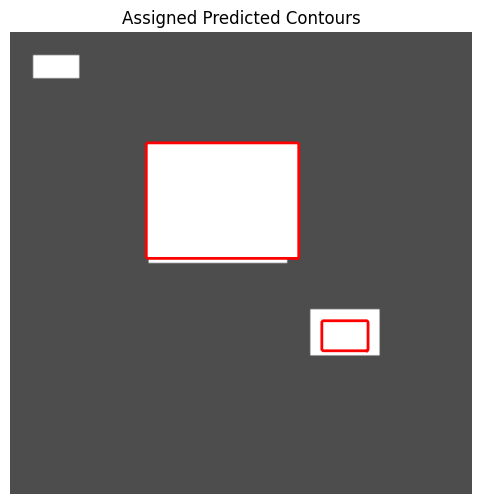

In [81]:
import numpy as np
from skimage.measure import label, regionprops, find_contours
from scipy.optimize import linear_sum_assignment

def filter_pred_contours_by_assignment(true_mask, pred_mask, max_dist=50):
    """
    Keep only the predicted contours that have a matching (assigned) object in the true image,
    and also return the assigned pairs (gt_label, pred_label, distance).

    1) Label both GT and pred masks.
    2) Match each GT object to the nearest predicted object by centroid distance (Hungarian).
    3) Collect the assigned predicted object labels (within max_dist).
    4) Build an 'assigned_pred_mask' with only those assigned objects.
    5) Extract contours from 'assigned_pred_mask'.
    
    Parameters:
      true_mask (np.array): 2D binary array for ground-truth.
      pred_mask (np.array): 2D binary array for predicted.
      max_dist (float): Max centroid distance threshold for valid assignment.
    
    Returns:
      final_contours (list of np.array): Each array is shape (N,2) of boundary coords (row,col)
                                         from assigned predicted objects.
      assigned_pairs (list of tuples): [(gt_label, pred_label, distance), ...] 
                                       for each matched pair that is within max_dist.
    """
    # 1) Label GT & predicted
    labeled_true = label(true_mask, connectivity=2)
    labeled_pred = label(pred_mask, connectivity=2)

    # 2) regionprops to get centroid info
    t_props = regionprops(labeled_true)
    p_props = regionprops(labeled_pred)
    
    # If no objects in GT or Pred => no assignment
    if len(t_props) == 0 or len(p_props) == 0:
        return [], []

    # Build cost matrix of centroid distances
    t_centroids = np.array([prop.centroid for prop in t_props])
    p_centroids = np.array([prop.centroid for prop in p_props])
    cost_matrix = np.linalg.norm(
        t_centroids[:, None, :] - p_centroids[None, :, :],
        axis=2
    )

    # Hungarian assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # 3) Collect assigned predicted labels + store assigned pairs
    assigned_pred_labels = set()
    assigned_pairs = []  # list of (gt_label, pred_label, distance)

    for i, j in zip(row_ind, col_ind):
        dist = cost_matrix[i, j]
        if dist <= max_dist:
            gt_label = t_props[i].label
            pr_label = p_props[j].label
            assigned_pred_labels.add(pr_label)
            assigned_pairs.append((gt_label, pr_label, dist))

    # 4) Build assigned predicted mask
    assigned_pred_mask = np.zeros_like(pred_mask, dtype=bool)
    for lbl in assigned_pred_labels:
        assigned_pred_mask[labeled_pred == lbl] = True

    # 5) Extract contours from assigned_pred_mask
    final_contours = find_contours(assigned_pred_mask, level=0.5)

    return final_contours, assigned_pairs

# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    # Simple demonstration
    H, W = 200, 200
    true_mask = np.zeros((H,W), dtype=bool)
    true_mask[50:100, 60:120] = True  # object1
    true_mask[120:140, 130:160] = True # object2

    pred_mask = np.zeros((H,W), dtype=bool)
    pred_mask[48:98, 59:125] = True    # near object1
    pred_mask[125:138, 135:155] = True # near object2
    pred_mask[10:20, 10:30] = True     # extra object, unassigned

    final_contours, assigned_pairs = filter_pred_contours_by_assignment(true_mask, pred_mask, max_dist=30)
    print(f"Number of final contours: {len(final_contours)}")
    print("Assigned pairs (gt_label, pred_label, distance):")
    for pair in assigned_pairs:
        print("  ", pair)

    # Plot
    plt.figure(figsize=(6,6))
    combined = np.maximum(true_mask, pred_mask)
    plt.imshow(combined, cmap='gray', alpha=0.7)
    # Plot each final contour
    for c in final_contours:
        plt.plot(c[:,1], c[:,0], 'r-', lw=2)
    plt.title("Assigned Predicted Contours")
    plt.axis("off")
    plt.show()


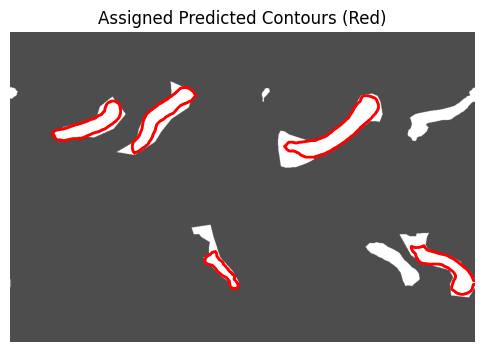

In [80]:
plot_assigned_pred_contours(true_mask1, pred_mask1, assigned_contour_p1)

Number of final contours: 4
Assigned pairs (gt_label, pred_label, distance):
   (1, 2, 7.755480484827233)
   (2, 5, 27.718654485793532)
   (3, 6, 18.739658470537776)
   (5, 9, 19.207644785439687)


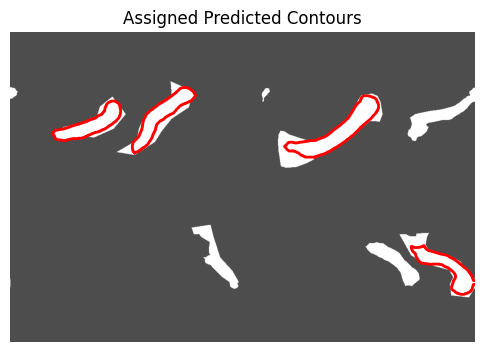

In [84]:
final_contours, assigned_pairs = filter_pred_contours_by_assignment(true_mask1, pred_mask1, max_dist=30)
print(f"Number of final contours: {len(final_contours)}")
print("Assigned pairs (gt_label, pred_label, distance):")
for pair in assigned_pairs:
    print("  ", pair)

    # Plot
plt.figure(figsize=(6,6))
combined = np.maximum(true_mask1, pred_mask1)
plt.imshow(combined, cmap='gray', alpha=0.7)
    # Plot each final contour
for c in final_contours:
    plt.plot(c[:,1], c[:,0], 'r-', lw=2)
plt.title("Assigned Predicted Contours")
plt.axis("off")
plt.show()

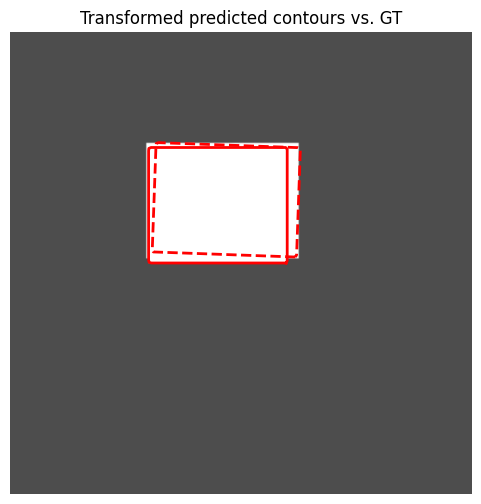

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours

############################################
# 1) Utility: Extract boundary points
############################################
def get_all_boundary_points(mask, level=0.5):
    contours = find_contours(mask, level=level)
    if len(contours)==0:
        return None
    # For simplicity, combine all contours
    all_pts = np.vstack(contours)
    return all_pts  # shape (N,2) => (row, col)

############################################
# 2) Build an affine matrix from Procrustes
############################################
def procrustes_transform_matrix(X, Y, allow_scaling=True):
    """
    Returns a 2x3 affine matrix M that maps points in Y -> best alignment with X.
    X, Y: shape (N,2) => (row,col)
    """
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)

    # Center them
    muX = X.mean(axis=0)
    muY = Y.mean(axis=0)
    X0 = X - muX
    Y0 = Y - muY

    normX = np.sqrt((X0**2).sum())
    normY = np.sqrt((Y0**2).sum())
    if normX < 1e-8 or normY < 1e-8:
        # degenerate => identity
        M = np.array([[1,0,0],[0,1,0]], dtype=np.float32)
        return M

    X0 /= normX
    Y0 /= normY

    A = X0.T @ Y0  # (2,2)
    U, s, Vt = np.linalg.svd(A)
    R = (U @ Vt).T  # rotation
    if allow_scaling:
        scale = s.sum() * (normX / normY)
    else:
        scale = 1.0

    SR = scale * R
    t = muX - (SR @ muY)

    # 2x3
    M = np.array([
        [SR[0,0], SR[0,1], t[0]],
        [SR[1,0], SR[1,1], t[1]]
    ], dtype=np.float32)
    return M


def resample_contour(contour, num_points=200):
    """
    Resample 'contour' (N,2) to exactly 'num_points' by arc-length interpolation.
    """
    import numpy as np
    distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
    cumdist = np.concatenate(([0], np.cumsum(distances)))
    total_len = cumdist[-1]

    new_distances = np.linspace(0, total_len, num_points)
    new_contour = np.empty((num_points, 2), dtype=contour.dtype)
    for d in [0,1]:
        new_contour[:, d] = np.interp(new_distances, cumdist, contour[:, d])
    return new_contour

def transform_points(points, M):
    """
    Apply 2x3 affine matrix M to points (N,2).
    points are (row,col).
    We interpret col->x, row->y for the transform.
    Return new shape (N,2).
    """
    N = points.shape[0]
    ones = np.ones((N,1), dtype=np.float32)
    # Homogeneous coords => x,y => col,row
    xy = np.column_stack([points[:,1], points[:,0]])  # shape (N,2)
    xy_hom = np.column_stack([xy, ones])              # shape (N,3)

    new_xy = (M @ xy_hom.T).T  # (N,2)
    # Convert back to (row,col)
    new_rc = np.column_stack([new_xy[:,1], new_xy[:,0]])
    return new_rc

############################################
# 3) Example: transform assigned predicted contour
############################################
def transform_and_plot(gt_mask, pred_mask, assigned_pairs):
    """
    assigned_pairs: list of (gt_obj_mask, pred_obj_mask)
                    each is a single-object mask after assignment.
    
    For each pair:
      - Extract boundaries
      - Procrustes => affine M
      - Transform predicted boundary
      - Plot
    """
    fig, ax = plt.subplots(figsize=(6,6))
    # Show GT + Pred for reference
    combined = np.maximum(gt_mask, pred_mask)
    ax.imshow(combined, cmap='gray', alpha=0.7)
    
    color_cycle = ['r','b','g','m','c','y']
    
    for idx, (gt_obj, pr_obj) in enumerate(assigned_pairs):
        color = color_cycle[idx % len(color_cycle)]
        
        gt_pts = get_all_boundary_points(gt_obj)
        pr_pts = get_all_boundary_points(pr_obj)
        gt_pts = resample_contour(gt_pts, 200)
        pr_pts = resample_contour(pr_pts, 200)
        
        
        if gt_pts is None or pr_pts is None:
            continue
        
        # Plot original GT boundary
        ax.plot(gt_pts[:,1], gt_pts[:,0], color+'-', lw=2)
        
        # Compute transform
        M = procrustes_transform_matrix(gt_pts, pr_pts, allow_scaling=True)
        
        # Transform predicted boundary
        pr_pts_trans = transform_points(pr_pts, M)
        
        # Plot transformed predicted boundary
        ax.plot(pr_pts_trans[:,1], pr_pts_trans[:,0], color+'--', lw=2)
    
    ax.set_title("Transformed predicted contours vs. GT")
    ax.axis("off")
    plt.show()


############################################
# Demo usage
############################################
if __name__ == "__main__":
    # Suppose we have a single GT mask and predicted mask with multiple objects,
    # we assigned them already, e.g. assigned_pairs is a list of (gt_obj, pr_obj).
    # For demonstration, let's create a toy example:

    H, W = 200, 200
    gt_mask = np.zeros((H,W), dtype=bool)
    gt_mask[50:100, 60:120] = True  # object1

    pred_mask = np.zeros((H,W), dtype=bool)
    pred_mask[48:98, 59:125] = True  # near object1

    # Suppose we have "assigned_pairs" as if we matched object1 in GT to object1 in Pred
    assigned_pairs = [(gt_mask, pred_mask)]

    transform_and_plot(gt_mask, pred_mask, assigned_pairs)


ValueError: too many values to unpack (expected 2)

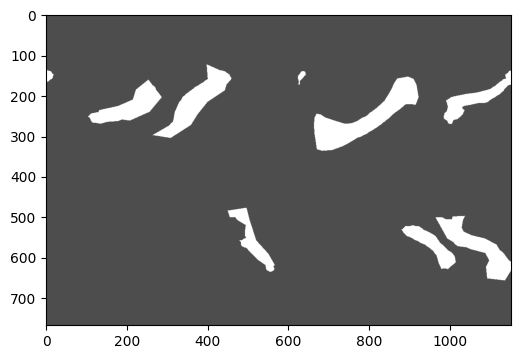

In [88]:
transform_and_plot(true_mask1, pred_mask1, assigned_pairs=assigned_pairs)

Import ar_count_files and compare it with climatenet files and draw 

In [ ]:
/home/sbk29/data/AR/ar_count_files

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
ar_count_files_0 = xr.open_dataset('/home/sbk29/data/AR/ar_count_files/ar_counts_eid_0.nc')



In [6]:
print(ar_count_files_0)

<xarray.Dataset> Size: 133MB
Dimensions:    (time: 80, lat: 361, lon: 576, max_count: 20)
Coordinates:
  * time       (time) datetime64[ns] 640B 2008-01-02T06:00:00 ... 2009-12-21T...
  * lat        (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
Dimensions without coordinates: max_count
Data variables:
    IVT        (time, lat, lon) float64 133MB ...
    AR_COUNT   (time) int32 320B ...
    click_x    (time, max_count) float64 13kB ...
    click_y    (time, max_count) float64 13kB ...
    click_lat  (time, max_count) float64 13kB ...
    click_lon  (time, max_count) float64 13kB ...
Attributes:
    originating_script:  /project/projectdirs/m1517/cascade/taobrien/artmip/t...
    repository:          https://bitbucket.org/taobrienlbl/ar_count_interface
    git_sha:             2ebec05


In [9]:
(ar_count_files_0.coords['time'].values)

array(['2008-01-02T06:00:00.000000000', '2008-01-10T09:00:00.000000000',
       '2008-01-10T21:00:00.000000000', '2008-01-22T06:00:00.000000000',
       '2008-02-07T06:00:00.000000000', '2008-02-15T18:00:00.000000000',
       '2008-02-16T03:00:00.000000000', '2008-02-29T00:00:00.000000000',
       '2008-03-05T15:00:00.000000000', '2008-03-10T21:00:00.000000000',
       '2008-04-20T18:00:00.000000000', '2008-04-25T12:00:00.000000000',
       '2008-04-27T03:00:00.000000000', '2008-06-08T18:00:00.000000000',
       '2008-06-19T00:00:00.000000000', '2008-06-19T09:00:00.000000000',
       '2008-07-05T21:00:00.000000000', '2008-07-15T12:00:00.000000000',
       '2008-07-18T18:00:00.000000000', '2008-08-06T18:00:00.000000000',
       '2008-08-11T21:00:00.000000000', '2008-08-18T00:00:00.000000000',
       '2008-08-22T21:00:00.000000000', '2008-09-01T12:00:00.000000000',
       '2008-09-09T09:00:00.000000000', '2008-09-15T06:00:00.000000000',
       '2008-10-04T12:00:00.000000000', '2008-10-19

In [15]:
# Convert to a Pandas DatetimeIndex (handles cftime objects, too)
t = pd.to_datetime(ar_count_files_0.coords["time"].values)
print(f"  • Earliest stamp : {t.min()}")
print(f"  • Latest stamp   : {t.max()}")
print(f"  • Span           : {(t.max() - t.min()).days} days\n")

  • Earliest stamp : 2008-01-02 06:00:00
  • Latest stamp   : 2009-12-21 09:00:00
  • Span           : 719 days



In [17]:
from pathlib import Path

In [18]:
ar_dir = Path("/home/sbk29/data/AR/ar_count_files/")